#### Progetto di corso per APPLICAZIONI DELL'INTELLIGENZA ARTIFICIALE (AA 2024-2025)
#### Stud: Marzio Della Bosca


Questo notebook si occupa di addestrate e valutare diverse architetture di reti neurali sui dati processati e salvati nei Notebook precedenti.

In [76]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import time
import os
import copy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device name: NVIDIA GeForce RTX 3050
Device: cuda


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class SimpleCNN(nn.Module):
    def __init__(self, input_channels, sequence_length, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        # Pooling per dimezzare la sequenza (n_feature diventa n_feature/2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # Calcola la dimensione flattened dopo conv e pooling
        flattened_size = 64 * (sequence_length // 2)
        
        # Un layer fully connected per produrre l'output finale
        self.fc = nn.Linear(flattened_size, num_classes)

    def forward(self, x):
        # Se l'input ha forma (batch, n_feature), diventa(batch, 1, n_feature) per forzare input a 2d
        if x.dim() == 2:
            x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x
    
class SimpleCNN2D(nn.Module):
    def __init__(self, channels, features, num_classes):
        super(SimpleCNN2D, self).__init__()

        # Convoluzioni
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)     
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                             # (N, -, H/2, W/2)
        self.relu = nn.ReLU()

        # Calcola la dimensione dell'output dopo convoluzioni e pooling
        c_out = channels // 2
        f_out = features // 2
        self.flattened_size = 64 * c_out * f_out  # 16 è il numero di canali dopo conv2

        # Fully connected
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))  
        x = self.relu(self.conv2(x))  
        x = self.pool(x)           # (N, -, H/2, W/2)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, n_epoche):
    best_val_loss = float("inf")    #  loss fornisce un'indicazione più fine e sensibile delle variazioni nelle prestazioni
    best_model_state = None     #   la funzione utilizzata per aggiornare i pesi; quindi, migliorie nella loss tendono a tradursi in migliori performance
    acc_vec = []
    loss_vec = []

    max_acc = -1
    min_acc = -1

    max_loss = -1
    min_loss = -1

    epoc_max_loss = -1
    epoc_min_loss = -1

    epoc_max_acc = -1
    epoc_min_acc = -1

    


    startT = time.time()

    for epoch in tqdm(range(n_epoche), desc="Training epochs.."):
        model.train()
        total_loss = 0.0
        total_samples = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

        # Valutazione
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device) 
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                total += yb.size(0)
                correct += (predicted == yb).sum().item()
                loss = criterion(outputs, yb)
                total_loss += loss.item() * xb.size(0)
                total_samples += xb.size(0)
        acc = correct / total
        acc_vec.append(acc)
        val_loss = total_loss / total_samples
        loss_vec.append(val_loss)

        if epoch == 0:
            max_acc = acc
            min_acc = acc
            max_loss = val_loss
            min_loss = val_loss
            epoc_max_loss = 1
            epoc_min_loss = 1
            epoc_max_acc = 1
            epoc_min_acc = 1
        

        if acc > max_acc:
            max_acc = acc
            epoc_max_acc = epoch + 1

        if acc < min_acc:
            min_acc = acc
            epoc_min_acc = epoch + 1

        if val_loss > max_loss:
            max_loss = val_loss
            epoc_max_loss = epoch + 1

        if val_loss < min_loss:
            min_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epoc_min_loss = epoch + 1

    print(f"Tempo totale di addestramento: {time.time() - startT:.2f} secondi")

    all_preds = []
    all_labels = []
    timeStart = time.time()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    print(f"Tempo di valutazione (predizioni): {time.time() - timeStart:.2f} secondi\n")

    print(f"Accuratezza finale: {acc_vec[-1]:.4f}")
    print(f"Accuratezza media: {np.mean(acc_vec):.4f}")

    print(f"Accuratezza minima: {np.min(acc_vec):.4f}, epoca: {epoc_min_acc}")
    print(f"Accuratezza massima: {np.max(acc_vec):.4f}, epoca: {epoc_max_acc}")

    print(f"Loss finale: {loss_vec[-1]:.4f}, epoca: {epoc_max_loss}")
    print(f"Loss media: {np.mean(loss_vec):.4f}")

    print(f"Loss minima: {np.min(loss_vec):.4f}, epoca: {epoc_min_loss}")
    print(f"Loss massima: {np.max(loss_vec):.4f}, epoca: {epoc_max_loss}\n")

    model.load_state_dict(best_model_state)

    return acc_vec, loss_vec, model

def loaders_maker(data, y, batch_S, seed):

    # Converte in tensori torch il modello da addestrare su dataset catch22
    feature_t = torch.tensor(data, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.long)

    x_train, x_val, y_train, y_val = train_test_split(feature_t, y_t, test_size=0.2, random_state=seed)

    # Dataset e DataLoader
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_S, shuffle=True, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_S, shuffle=False, pin_memory=True)

    return train_loader, val_loader

def plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche):
    mean_acc_tsfel = np.mean(acc_tsfel, axis=0)
    std_acc_tsfel = np.std(acc_tsfel, axis=0)
    min_acc_tsfel = np.min(acc_tsfel)  
    max_acc_tsfel = np.max(acc_tsfel) 

    mean_acc_catch22 = np.mean(acc_catch22, axis=0)
    std_acc_catch22 = np.std(acc_catch22, axis=0)
    min_acc_catch22 = np.min(acc_catch22)  
    max_acc_catch22 = np.max(acc_catch22)  

    mean_loss_tsfel = np.mean(loss_tsfel, axis=0)
    std_loss_tsfel = np.std(loss_tsfel, axis=0)
    min_loss_tsfel = np.min(loss_tsfel)  
    max_loss_tsfel = np.max(loss_tsfel)  

    mean_loss_catch22 = np.mean(loss_catch22, axis=0)
    std_loss_catch22 = np.std(loss_catch22, axis=0)
    min_loss_catch22 = np.min(loss_catch22)  
    max_loss_catch22 = np.max(loss_catch22)  

    plt.figure(figsize=(16, 8))
    # TSFEL
    plt.plot(mean_acc_tsfel, label=f"TSFEL (Media: {mean_acc_tsfel[-1]:.4f}, Min: {min_acc_tsfel:.4f}, Max: {max_acc_tsfel:.4f}, Std: {std_acc_tsfel[-1]:.4f})", color='blue')
    plt.fill_between(range(len(mean_acc_tsfel)), 
                    mean_acc_tsfel - std_acc_tsfel, 
                    mean_acc_tsfel + std_acc_tsfel, 
                    color='blue', alpha=0.3)

    # CATCH22
    plt.plot(mean_acc_catch22, label=f"CATCH22 (Media: {mean_acc_catch22[-1]:.4f}, Min: {min_acc_catch22:.4f}, Max: {max_acc_catch22:.4f}, Std: {std_acc_catch22[-1]:.4f})", color='orange')
    plt.fill_between(range(len(mean_acc_catch22)), 
                    mean_acc_catch22 - std_acc_catch22, 
                    mean_acc_catch22 + std_acc_catch22, 
                    color='orange', alpha=0.3)

    plt.title('Accuratezza Media per Epoca con Intervalli di Confidenza - seed = 64, 256, 571')
    plt.xticks(np.arange(0, n_epoche, step=10))
    plt.xlabel('Epoche')
    plt.ylabel('Accuratezza')
    plt.legend()
    plt.grid()
    plt.show()

    # Loss media con intervalli di confidenza
    plt.figure(figsize=(16, 8))
    mean_loss_tsfel = np.mean(loss_tsfel, axis=0)
    std_loss_tsfel = np.std(loss_tsfel, axis=0)
    mean_loss_catch22 = np.mean(loss_catch22, axis=0)
    std_loss_catch22 = np.std(loss_catch22, axis=0)

    # TSFEL
    plt.plot(mean_loss_tsfel, label=f"TSFEL (Media: {mean_loss_tsfel[-1]:.4f}, Min: {min_loss_tsfel:.4f}, Max: {max_loss_tsfel:.4f}, Std: {std_loss_tsfel[-1]:.4f})", color='blue')
    plt.fill_between(range(len(mean_loss_tsfel)), 
                    mean_loss_tsfel - std_loss_tsfel, 
                    mean_loss_tsfel + std_loss_tsfel, 
                    color='blue', alpha=0.3)

    # CATCH22
    plt.plot(mean_loss_catch22, label=f"CATCH22 (Media: {mean_loss_catch22[-1]:.4f}, Min: {min_loss_catch22:.4f}, Max: {max_loss_catch22:.4f}, Std: {std_loss_catch22[-1]:.4f})", color='orange')
    plt.fill_between(range(len(mean_loss_catch22)), 
                    mean_loss_catch22 - std_loss_catch22, 
                    mean_loss_catch22 + std_loss_catch22, 
                    color='orange', alpha=0.3)


    plt.title('Loss Media per Epoca con Intervalli di Confidenza - seed = 64, 256, 571')
    plt.xticks(np.arange(0, n_epoche, step=10))
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_model(model, X, y, device, batch_size):
    model.to(device)
    model.eval()

    # Se X e y sono numpy array, convertili in tensori
    if isinstance(X, np.ndarray):
        X = torch.tensor(X, dtype=torch.float32)
    if isinstance(y, np.ndarray):
        y = torch.tensor(y, dtype=torch.long)
    
    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            yb = yb.to(device)
            outputs = model(xb)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    confusion_mat = confusion_matrix(all_labels, all_preds)

    return confusion_mat, acc, all_preds, all_labels

def estimate_model_size(model, quantized=False):
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    bytes_per_param = 1 if quantized else 4
    size_bytes = param_count * bytes_per_param
    size_mb = size_bytes / (1024 * 1024)
    return size_mb

def estimate_total_inference_memory(model, input_shape, quantized=False, activation_factor=1.5):
    # Stima della memoria occupata dai parametri
    model_size_mb = estimate_model_size(model, quantized=quantized)
    
    
    param_count = 1
    for dim in input_shape:
        param_count *= dim
        
    bytes_per_element = 1 if quantized else 4
    input_size_bytes = param_count * bytes_per_element
    input_size_mb = input_size_bytes / (1024 * 1024)
    
    # La memoria totale include il modello più l'input (moltiplicato da un fattore per gli overhead)
    total_memory_mb = model_size_mb + input_size_mb * activation_factor
    return total_memory_mb

def plot_confusion_graph(c, labels, title=""):

    colors = cm.tab10.colors[:len(labels)]
    class_color_map = dict(zip(labels, colors))
    
    G = nx.DiGraph()
    
    row_sums = c.sum(axis=1)
    for label, total in zip(labels, row_sums):
        G.add_node(label, size=total)
    
    exponent = 2
    # Aggiunge archi per ogni mismatch 
    for i, label_i in enumerate(labels):
        # Calcola il totale degli errori per classe
        total_errors = sum(c[i, j] for j in range(len(labels)) if j != i)
        for j, label_j in enumerate(labels):
            if i != j and c[i, j] > 0:
                # calcola il peso lineare e poi lo eleva alla potenza (evidenzia mismatch)
                norm_linear = (c[i, j] / total_errors) * 4 if total_errors > 0 else 0
                norm_weight = norm_linear ** exponent
                G.add_edge(label_i, label_j, weight=norm_weight, count=c[i, j])
    
    pos = nx.circular_layout(G)
    
    # Scala le dimensioni dei nodi
    node_sizes = [G.nodes[n]['size'] / 100 * 5 for n in G.nodes]
    edge_widths = [G[u][v]['weight'] for u, v in G.edges]
    
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray',
                           arrows=True, arrowstyle='->', arrowsize=30,
                           connectionstyle='arc3,rad=0.3')
    
    node_colors = [class_color_map[n] for n in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.5)
    nx.draw_networkx_labels(G, pos)
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [62]:
catch22 = np.load('catch22_uni.npy')
tsfel = np.load('tsfel_uni.npy')
y = np.load('labels_uni.npy')

print(f"Shape catch22: {catch22.shape}")
print(f"Shape tsfel: {tsfel.shape}")
print(f"Shape labels: {y.shape}")

Shape catch22: (375358, 132)
Shape tsfel: (375358, 270)
Shape labels: (375358,)


In [ ]:
print(np.isnan(catch22).any(), np.isinf(catch22).any())
print(np.isnan(tsfel).any(), np.isinf(tsfel).any())

nan_indices_catch22 = np.where(np.isnan(catch22))
print("Indici dei NaN in catch22:", nan_indices_catch22)

nan_indices_tsfel = np.where(np.isnan(tsfel))
print("Indici dei NaN in tsfel:", nan_indices_tsfel)

False False
False False
Indici dei NaN in catch22: (array([], dtype=int64), array([], dtype=int64))
Indici dei NaN in tsfel: (array([], dtype=int64), array([], dtype=int64))


In [ ]:
# Controlla la distribuzione originale delle classi
print("Distribuzione originale delle classi:", Counter(y))

min_class_count = min(Counter(y).values())

# Indici bilanciati con selezione casuale
balanced_indices = []
np.random.seed(42)  
for label in np.unique(y):
    label_indices = np.where(y == label)[0]
    # Seleziona casualmente 'min_class_count' indici per ogni classe
    selected_indices = np.random.choice(label_indices, min_class_count, replace=False)
    balanced_indices.extend(selected_indices)

np.random.shuffle(balanced_indices)

catch22_bal = catch22[balanced_indices]
tsfel_bal = tsfel[balanced_indices]
y_bal = y[balanced_indices]

print("Distribuzione bilanciata delle classi:", Counter(y_bal))
print(f"Shape catch22_balanced: {catch22_bal.shape}")
print(f"Shape tsfel_balanced: {tsfel_bal.shape}")
print(f"Shape labels_balanced: {y_bal.shape}")

Distribuzione originale delle classi: Counter({np.int64(0): 109828, np.int64(1): 109462, np.int64(3): 41617, np.int64(2): 41018, np.int64(5): 36966, np.int64(4): 36467})
Distribuzione bilanciata delle classi: Counter({np.int64(0): 36467, np.int64(3): 36467, np.int64(2): 36467, np.int64(4): 36467, np.int64(5): 36467, np.int64(1): 36467})
Shape catch22_balanced: (218802, 132)
Shape tsfel_balanced: (218802, 270)
Shape labels_balanced: (218802,)


In [13]:
lr = 1e-4
seed = 42
criterion = nn.CrossEntropyLoss()


model_tsfel_bal = SimpleMLP(input_dim=tsfel_bal.shape[1], num_classes=6)
model_catch22_bal = SimpleMLP(input_dim=catch22_bal.shape[1], num_classes=6)

model_tsfel = SimpleMLP(input_dim=tsfel.shape[1], num_classes=6)
model_catch22 = SimpleMLP(input_dim=catch22.shape[1], num_classes=6)

optimizer_catch22_bal = optim.Adam(model_catch22_bal.parameters(), lr=lr)
optimizer_tsfel_bal = optim.Adam(model_tsfel_bal.parameters(), lr=lr)

optimizer_catch22 = optim.Adam(model_catch22.parameters(), lr=lr)
optimizer_tsfel = optim.Adam(model_tsfel.parameters(), lr=lr)

batch_size = 1024

# Confronto Accuracy per dati sbilanciati e bilanciati
train_loader_tsfel_bal, val_loader_tsfel_bal = loaders_maker(tsfel_bal, y_bal, batch_size, seed) # bilanciati

startT = time.time()
acc_vec_tsfel, loss_vec_tsfel, mlp_tsfel_bal = train_model(model_tsfel_bal.to(device), train_loader_tsfel_bal, val_loader_tsfel_bal, criterion, optimizer_tsfel_bal, 100)
print(f"Tempo di esecuzione TSFEL bilanciato: {time.time() - startT:.2f} secondi\n")

train_loader_catch22_bal, val_loader_catch22_bal = loaders_maker(catch22_bal, y_bal, batch_size, seed)

startT = time.time()
acc_vec_catch22, loss_vec_catch22, mlp_cacth22_bal = train_model(model_catch22_bal.to(device), train_loader_catch22_bal, val_loader_catch22_bal, criterion, optimizer_catch22_bal, 100)
print(f"\nTempo di esecuzione CATCH22 bilanciato: {time.time() - startT:.2f} secondi\n")

train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel, y, batch_size, seed) # sbilanciati

startT = time.time()
acc_vec_tsfel, loss_vec_tsfel, mlp_tsfel_sbal = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer_tsfel, 100)
print(f"\nTempo di esecuzione TSFEL sbilanciato: {time.time() - startT:.2f} secondi\n")

train_loader_catch22, val_loader_catch22 = loaders_maker(catch22, y, batch_size, seed)

startT = time.time()
acc_vec_catch22, loss_vec_catch22, mlp_cacth22_sbal = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer_catch22, 100)
print(f"\nTempo di esecuzione CATCH22 sbilanciato: {time.time() - startT:.2f} secondi\n")

Training epochs..: 100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


Tempo totale di addestramento: 188.86 secondi
Tempo di valutazione (predizioni): 0.43 secondi

Accuratezza finale: 0.8898
Accuratezza media: 0.8625
Accuratezza minima: 0.6124, epoca: 1
Accuratezza massima: 0.8900, epoca: 98
Loss finale: 0.3111, epoca: 1
Loss media: 0.3837
Loss minima: 0.3111, epoca: 100
Loss massima: 1.0421, epoca: 1

Tempo di esecuzione TSFEL bilanciato: 189.29 secondi



Training epochs..: 100%|██████████| 100/100 [03:32<00:00,  2.12s/it]


Tempo totale di addestramento: 212.19 secondi
Tempo di valutazione (predizioni): 0.52 secondi

Accuratezza finale: 0.8286
Accuratezza media: 0.7911
Accuratezza minima: 0.5591, epoca: 1
Accuratezza massima: 0.8286, epoca: 100
Loss finale: 0.4724, epoca: 1
Loss media: 0.5625
Loss minima: 0.4724, epoca: 100
Loss massima: 1.1760, epoca: 1


Tempo di esecuzione CATCH22 bilanciato: 212.71 secondi



Training epochs..: 100%|██████████| 100/100 [06:28<00:00,  3.88s/it]


Tempo totale di addestramento: 388.17 secondi
Tempo di valutazione (predizioni): 0.76 secondi

Accuratezza finale: 0.9273
Accuratezza media: 0.9103
Accuratezza minima: 0.7536, epoca: 1
Accuratezza massima: 0.9274, epoca: 96
Loss finale: 0.2290, epoca: 1
Loss media: 0.2780
Loss minima: 0.2290, epoca: 100
Loss massima: 0.7373, epoca: 1


Tempo di esecuzione TSFEL sbilanciato: 388.93 secondi



Training epochs..: 100%|██████████| 100/100 [06:12<00:00,  3.73s/it]


Tempo totale di addestramento: 372.76 secondi
Tempo di valutazione (predizioni): 0.66 secondi

Accuratezza finale: 0.8834
Accuratezza media: 0.8605
Accuratezza minima: 0.6972, epoca: 1
Accuratezza massima: 0.8834, epoca: 100
Loss finale: 0.3523, epoca: 1
Loss media: 0.4155
Loss minima: 0.3523, epoca: 100
Loss massima: 0.8727, epoca: 1


Tempo di esecuzione CATCH22 sbilanciato: 373.43 secondi



In [14]:
torch.save(mlp_tsfel_bal.state_dict(), "mlp_tsfel_bal.pth")
torch.save(mlp_cacth22_bal.state_dict(), "mlp_cacth22_bal.pth")
torch.save(mlp_tsfel_sbal.state_dict(), "mlp_tsfel_sbal.pth")
torch.save(mlp_cacth22_sbal.state_dict(), "mlp_cacth22_sbal.pth")

In [23]:
mlp_tsfel_bal = SimpleMLP(input_dim=tsfel_bal.shape[1], num_classes=6)
mlp_cacth22_bal = SimpleMLP(input_dim=catch22_bal.shape[1], num_classes=6)
mlp_tsfel_sbal = SimpleMLP(input_dim=tsfel.shape[1], num_classes=6)
mlp_cacth22_sbal = SimpleMLP(input_dim=catch22.shape[1], num_classes=6) 

mlp_tsfel_bal.load_state_dict(torch.load("mlp_tsfel_bal.pth"))
mlp_cacth22_bal.load_state_dict(torch.load("mlp_cacth22_bal.pth"))
mlp_tsfel_sbal.load_state_dict(torch.load("mlp_tsfel_sbal.pth"))
mlp_cacth22_sbal.load_state_dict(torch.load("mlp_cacth22_sbal.pth"))

<All keys matched successfully>

In [15]:
# Test sugli mlp
# 0-Walking, 1-Jogging, 2-DownStairs, 3-UpStairs, 4-Sitting, 5-Standing
n_epoche = 100
seeds = [64, 256, 571]
batch_size = 1024
criterion = nn.CrossEntropyLoss()
lr = 1e-4

acc_tsfel = []
acc_catch22 = []

loss_tsfel = []
loss_catch22 = []

execution_tsfel_times = []
execution_catch22_times = []

for seed in seeds:
    print(f"Seed: {seed}")
    
    model_tsfel = SimpleMLP(input_dim=tsfel.shape[1], num_classes=6)
    model_catch22 = SimpleMLP(input_dim=catch22.shape[1], num_classes=6)

    train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel, y, batch_size, seed)
    optimizer = optim.Adam(model_tsfel.parameters(), lr=lr)

    startT = time.time()
    acc_vec_tsfel, loss_vec_tsfel, mlp_tsfel_1 = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer, n_epoche)
    execution_tsfel_times.append(time.time() - startT)

    acc_tsfel.append(acc_vec_tsfel)
    loss_tsfel.append(loss_vec_tsfel)

    train_loader_catch22, val_loader_catch22 = loaders_maker(catch22, y, batch_size, seed)
    optimizer = optim.Adam(model_catch22.parameters(), lr=lr)

    startT = time.time()
    acc_vec_catch22, loss_vec_catch22, mlp_catch22_1 = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer, n_epoche)
    execution_catch22_times.append(time.time() - startT)
    
    acc_catch22.append(acc_vec_catch22)
    loss_catch22.append(loss_vec_catch22)


Seed: 64


Training epochs..: 100%|██████████| 100/100 [06:10<00:00,  3.71s/it]


Tempo totale di addestramento: 370.92 secondi
Tempo di valutazione (predizioni): 0.67 secondi

Accuratezza finale: 0.9242
Accuratezza media: 0.9087
Accuratezza minima: 0.7613, epoca: 1
Accuratezza massima: 0.9244, epoca: 98
Loss finale: 0.2339, epoca: 1
Loss media: 0.2795
Loss minima: 0.2317, epoca: 99
Loss massima: 0.7232, epoca: 1



Training epochs..: 100%|██████████| 100/100 [06:34<00:00,  3.94s/it]


Tempo totale di addestramento: 394.08 secondi
Tempo di valutazione (predizioni): 0.82 secondi

Accuratezza finale: 0.8826
Accuratezza media: 0.8591
Accuratezza minima: 0.6864, epoca: 1
Accuratezza massima: 0.8828, epoca: 99
Loss finale: 0.3564, epoca: 1
Loss media: 0.4195
Loss minima: 0.3562, epoca: 99
Loss massima: 0.8904, epoca: 1

Seed: 256


Training epochs..: 100%|██████████| 100/100 [06:15<00:00,  3.75s/it]


Tempo totale di addestramento: 375.26 secondi
Tempo di valutazione (predizioni): 0.84 secondi

Accuratezza finale: 0.9280
Accuratezza media: 0.9110
Accuratezza minima: 0.7518, epoca: 1
Accuratezza massima: 0.9282, epoca: 98
Loss finale: 0.2238, epoca: 1
Loss media: 0.2737
Loss minima: 0.2238, epoca: 100
Loss massima: 0.7395, epoca: 1



Training epochs..: 100%|██████████| 100/100 [06:20<00:00,  3.81s/it]


Tempo totale di addestramento: 380.80 secondi
Tempo di valutazione (predizioni): 0.74 secondi

Accuratezza finale: 0.8852
Accuratezza media: 0.8608
Accuratezza minima: 0.6935, epoca: 1
Accuratezza massima: 0.8852, epoca: 100
Loss finale: 0.3497, epoca: 1
Loss media: 0.4145
Loss minima: 0.3497, epoca: 99
Loss massima: 0.8827, epoca: 1

Seed: 571


Training epochs..: 100%|██████████| 100/100 [06:41<00:00,  4.02s/it]


Tempo totale di addestramento: 401.72 secondi
Tempo di valutazione (predizioni): 0.70 secondi

Accuratezza finale: 0.9262
Accuratezza media: 0.9097
Accuratezza minima: 0.7586, epoca: 1
Accuratezza massima: 0.9262, epoca: 100
Loss finale: 0.2320, epoca: 1
Loss media: 0.2786
Loss minima: 0.2320, epoca: 100
Loss massima: 0.7286, epoca: 1



Training epochs..: 100%|██████████| 100/100 [05:40<00:00,  3.40s/it]


Tempo totale di addestramento: 340.43 secondi
Tempo di valutazione (predizioni): 0.87 secondi

Accuratezza finale: 0.8828
Accuratezza media: 0.8602
Accuratezza minima: 0.6902, epoca: 1
Accuratezza massima: 0.8830, epoca: 97
Loss finale: 0.3532, epoca: 1
Loss media: 0.4151
Loss minima: 0.3519, epoca: 99
Loss massima: 0.8820, epoca: 1



In [21]:
torch.save(mlp_tsfel_1.state_dict(), "mlp_tsfel_1.pth")
torch.save(mlp_catch22_1.state_dict(), "mlp_catch22_1.pth")

In [22]:
mlp_tsfel_1 = SimpleMLP(input_dim=tsfel.shape[1], num_classes=6)
mlp_catch22_1 = SimpleMLP(input_dim=catch22.shape[1], num_classes=6)

mlp_tsfel_1.load_state_dict(torch.load("mlp_tsfel_1.pth"))
mlp_catch22_1.load_state_dict(torch.load("mlp_catch22_1.pth"))

<All keys matched successfully>

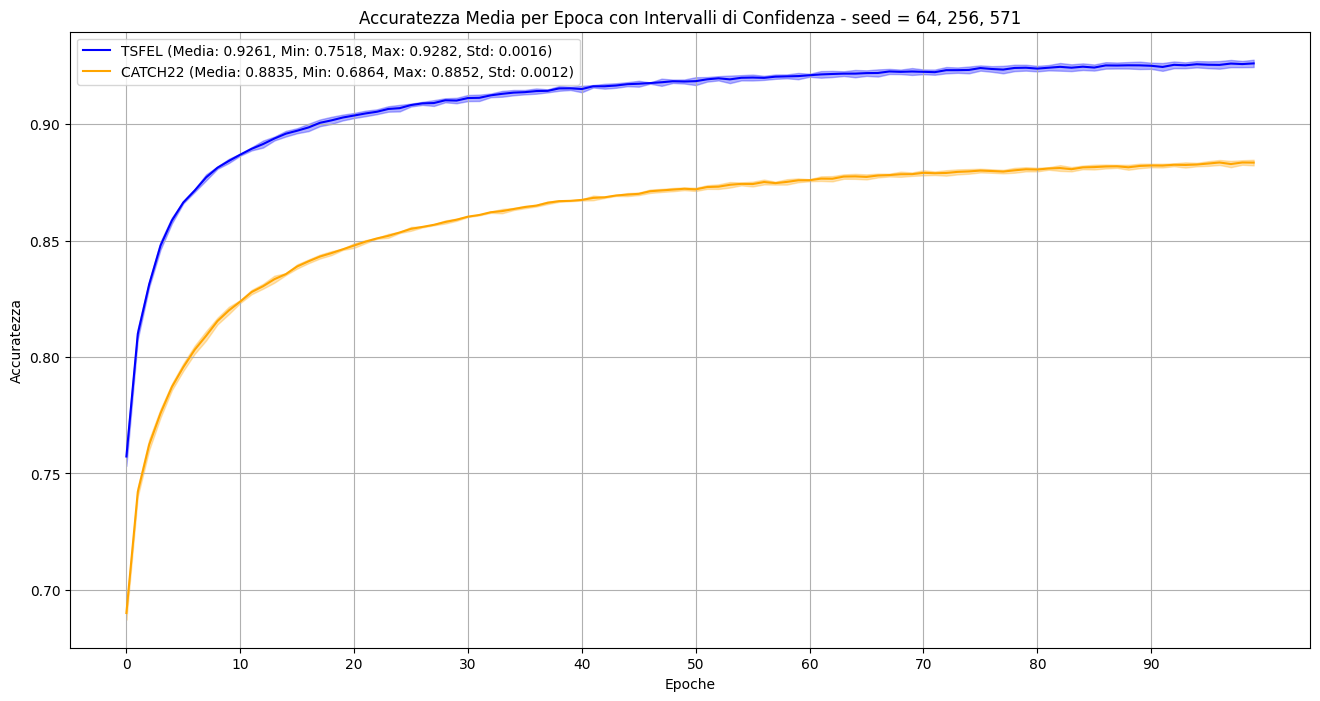

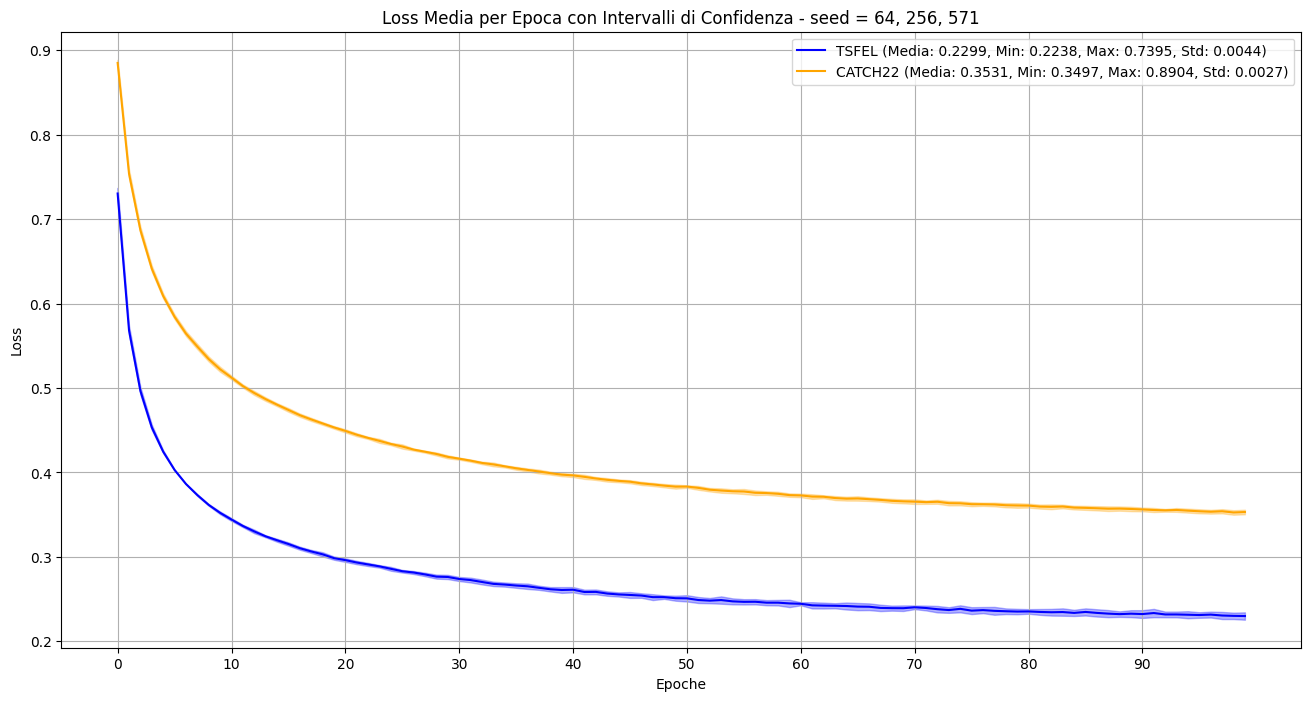

In [20]:
plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche)

In [ ]:
n_epoche = 100
seeds = [64, 256, 571]
batch_size = 1024
criterion = nn.CrossEntropyLoss()
lr = 1e-4

acc_tsfel = []
acc_catch22 = []

loss_tsfel = []
loss_catch22 = []

execution_tsfel_times = []
execution_catch22_times = []

for seed in seeds:
    # test su cnn
    print(f"Seed: {seed}")
    model_tsfel = SimpleCNN(input_channels=1, sequence_length=tsfel.shape[1], num_classes=6)
    model_catch22 = SimpleCNN(input_channels=1, sequence_length=catch22.shape[1], num_classes=6)

    train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel.reshape(tsfel.shape[0], 1, tsfel.shape[1]), y, batch_size, seed)
    optimizer = optim.Adam(model_tsfel.parameters(), lr=lr)
    startT = time.time()
    acc_vec_tsfel, loss_vec_tsfel, cnn_tsfel_1 = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer, n_epoche)
    
    execution_tsfel_times.append(time.time() - startT)
    acc_tsfel.append(acc_vec_tsfel)
    loss_tsfel.append(loss_vec_tsfel)
    
    train_loader_catch22, val_loader_catch22 = loaders_maker(catch22.reshape(catch22.shape[0], 1, catch22.shape[1]), y, batch_size, seed)
    optimizer = optim.Adam(model_catch22.parameters(), lr=lr)
    startT = time.time()
    acc_vec_catch22, loss_vec_catch22, cnn_catch22_1 = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer, n_epoche)
    
    execution_catch22_times.append(time.time() - startT)
    acc_catch22.append(acc_vec_catch22)
    loss_catch22.append(loss_vec_catch22)


Seed: 64


Training epochs..: 100%|██████████| 100/100 [06:55<00:00,  4.16s/it]


Tempo totale di addestramento: 416.00 secondi
Tempo di valutazione (predizioni): 0.79 secondi

Accuratezza finale: 0.8971
Accuratezza media: 0.8822
Accuratezza minima: 0.7942, epoca: 1
Accuratezza massima: 0.8977, epoca: 97
Loss finale: 0.3137, epoca: 1
Loss media: 0.3595
Loss minima: 0.3137, epoca: 100
Loss massima: 0.6442, epoca: 1



Training epochs..: 100%|██████████| 100/100 [06:18<00:00,  3.79s/it]


Tempo totale di addestramento: 378.59 secondi
Tempo di valutazione (predizioni): 0.85 secondi

Accuratezza finale: 0.8396
Accuratezza media: 0.8222
Accuratezza minima: 0.7203, epoca: 1
Accuratezza massima: 0.8407, epoca: 99
Loss finale: 0.4722, epoca: 1
Loss media: 0.5231
Loss minima: 0.4712, epoca: 99
Loss massima: 0.8189, epoca: 1

Seed: 256


Training epochs..: 100%|██████████| 100/100 [06:44<00:00,  4.05s/it]


Tempo totale di addestramento: 404.69 secondi
Tempo di valutazione (predizioni): 1.01 secondi

Accuratezza finale: 0.9015
Accuratezza media: 0.8862
Accuratezza minima: 0.7955, epoca: 1
Accuratezza massima: 0.9023, epoca: 98
Loss finale: 0.3066, epoca: 1
Loss media: 0.3499
Loss minima: 0.3059, epoca: 98
Loss massima: 0.6378, epoca: 1



Training epochs..: 100%|██████████| 100/100 [06:24<00:00,  3.84s/it]


Tempo totale di addestramento: 384.15 secondi
Tempo di valutazione (predizioni): 0.52 secondi

Accuratezza finale: 0.8427
Accuratezza media: 0.8247
Accuratezza minima: 0.7163, epoca: 1
Accuratezza massima: 0.8436, epoca: 99
Loss finale: 0.4651, epoca: 1
Loss media: 0.5170
Loss minima: 0.4635, epoca: 99
Loss massima: 0.8255, epoca: 1

Seed: 571


Training epochs..: 100%|██████████| 100/100 [06:43<00:00,  4.03s/it]


Tempo totale di addestramento: 403.18 secondi
Tempo di valutazione (predizioni): 0.97 secondi

Accuratezza finale: 0.8983
Accuratezza media: 0.8850
Accuratezza minima: 0.8004, epoca: 1
Accuratezza massima: 0.8994, epoca: 97
Loss finale: 0.3096, epoca: 1
Loss media: 0.3528
Loss minima: 0.3091, epoca: 99
Loss massima: 0.6278, epoca: 1



Training epochs..: 100%|██████████| 100/100 [06:23<00:00,  3.83s/it]


Tempo totale di addestramento: 383.29 secondi
Tempo di valutazione (predizioni): 0.79 secondi

Accuratezza finale: 0.8441
Accuratezza media: 0.8245
Accuratezza minima: 0.7211, epoca: 1
Accuratezza massima: 0.8441, epoca: 100
Loss finale: 0.4674, epoca: 1
Loss media: 0.5199
Loss minima: 0.4674, epoca: 100
Loss massima: 0.8210, epoca: 1



In [30]:
torch.save(cnn_tsfel_1.state_dict(), "cnn_tsfel_1.pth")
torch.save(cnn_catch22_1.state_dict(), "cnn_catch22_1.pth")

In [31]:
cnn_tsfel_1 = SimpleCNN(input_channels=1, sequence_length=tsfel.shape[1], num_classes=6)
cnn_catch22_1 = SimpleCNN(input_channels=1, sequence_length=catch22.shape[1], num_classes=6)

cnn_tsfel_1.load_state_dict(torch.load("cnn_tsfel_1.pth"))
cnn_catch22_1.load_state_dict(torch.load("cnn_catch22_1.pth"))

<All keys matched successfully>

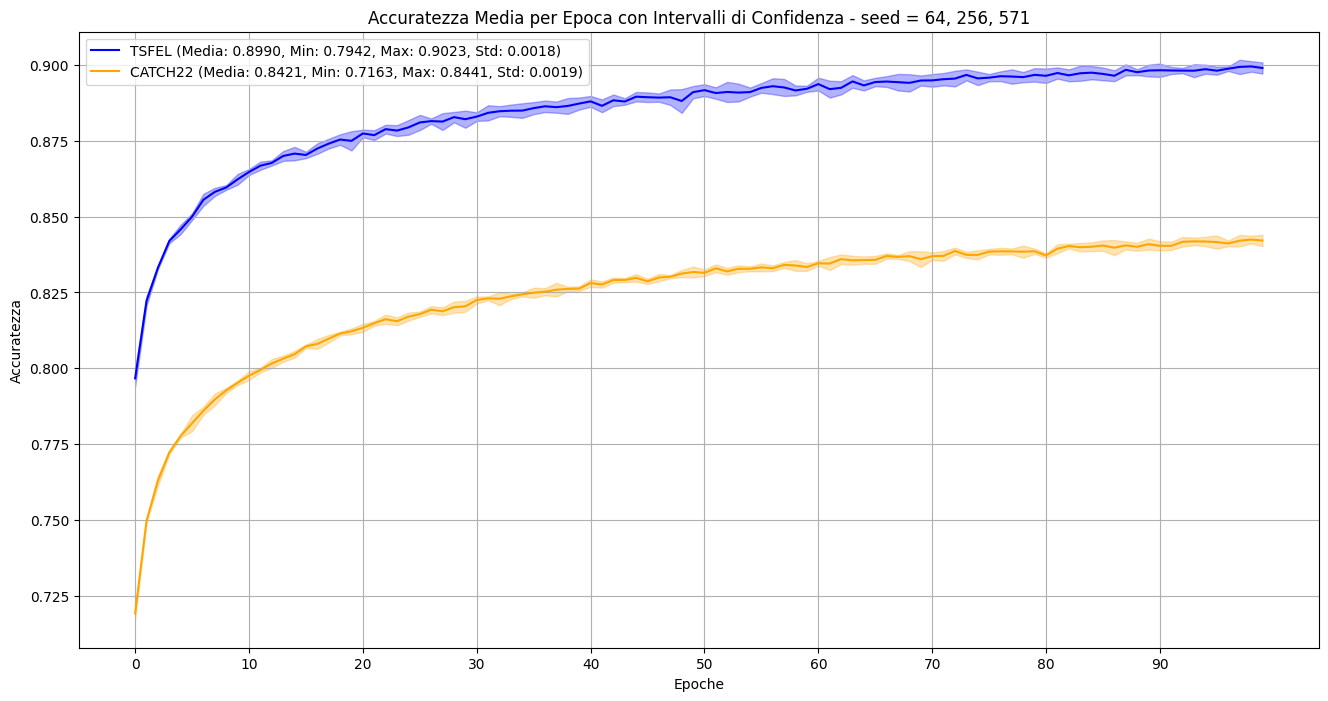

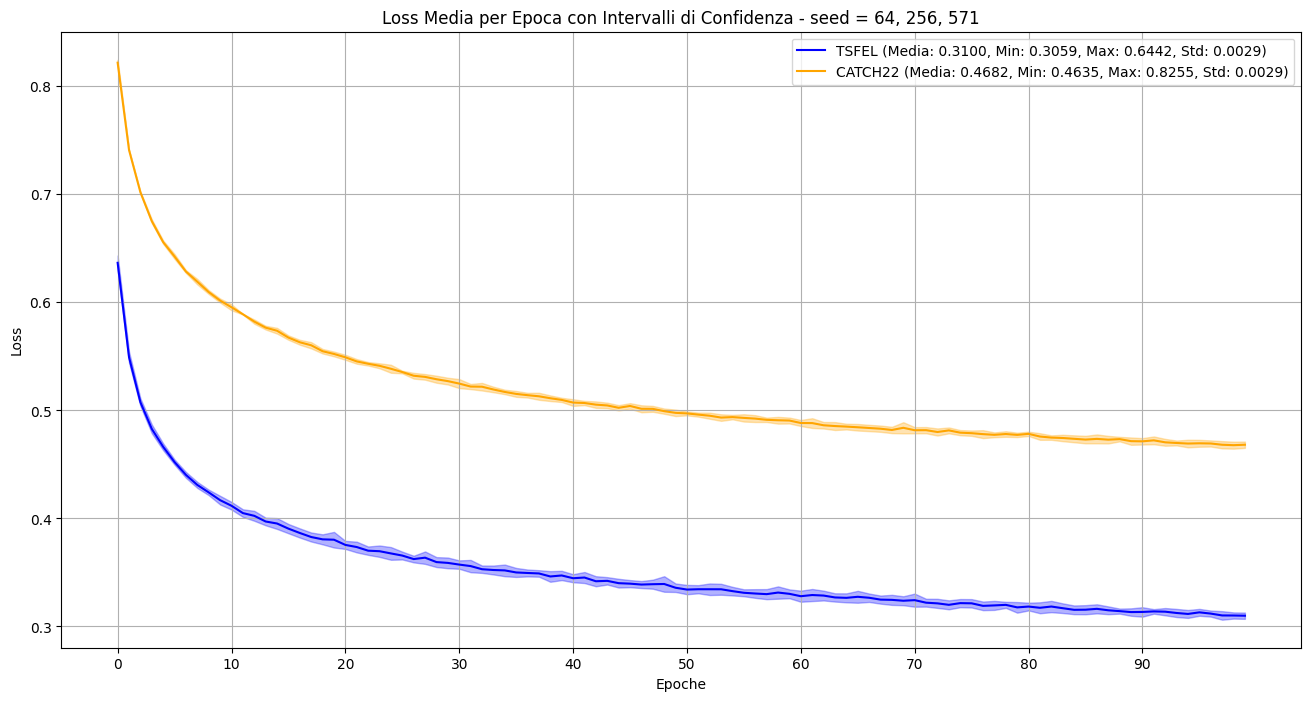

In [32]:
plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche)

In [ ]:
# Prova con CNN 2d : trattare rappresentazione tsfel e catch22 come immagini
catch22_3d = np.load('catch22_3d_uni.npy')
tsfel_3d = np.load('tsfel_3d_uni.npy')
y_3d = np.load('labels_3d_uni.npy')

print(f"Shape catch22_3d: {catch22_3d.shape}")
print(f"Shape tsfel_3d: {tsfel_3d.shape}")
print(f"Shape labels_3d: {y_3d.shape}")

Shape catch22_3d: (58912, 6, 22)
Shape tsfel_3d: (58912, 6, 45)
Shape labels_3d: (58912,)


In [ ]:
# Reshaping per CNN 2D
catch22_3d = np.expand_dims(catch22_3d, axis=1)
tsfel_3d = np.expand_dims(tsfel_3d, axis=1)

print(f"Shape catch22_3d reshaped: {catch22_3d.shape}")
print(f"Shape tsfel_3d reshaped: {tsfel_3d.shape}")

Shape catch22_3d reshaped: (58912, 1, 6, 22)
Shape tsfel_3d reshaped: (58912, 1, 6, 45)


In [40]:
n_epoche = 100
seeds = [64, 256, 571]
batch_size = 1024
criterion = nn.CrossEntropyLoss()
lr = 1e-4

acc_tsfel = []
acc_catch22 = []

loss_tsfel = []
loss_catch22 = []

execution_tsfel_times = []
execution_catch22_times = []

for seed in seeds:
    print(f"Seed: {seed}")
    
    model_tsfel = SimpleCNN2D(channels=tsfel_3d.shape[2], features=tsfel_3d.shape[3], num_classes=6)
    model_catch22 = SimpleCNN2D(channels=catch22_3d.shape[2], features=catch22_3d.shape[3], num_classes=6)

    train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel_3d, y_3d, batch_size, seed)
    optimizer = optim.Adam(model_tsfel.parameters(), lr=lr)

    startT = time.time()
    acc_vec_tsfel, loss_vec_tsfel, cnn_tsfel_2 = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer, n_epoche)
    execution_tsfel_times.append(time.time() - startT)

    acc_tsfel.append(acc_vec_tsfel)
    loss_tsfel.append(loss_vec_tsfel)

    train_loader_catch22, val_loader_catch22 = loaders_maker(catch22_3d, y_3d, batch_size, seed)
    optimizer = optim.Adam(model_catch22.parameters(), lr=lr)

    startT = time.time()
    acc_vec_catch22, loss_vec_catch22, cnn_catch22_2 = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer, n_epoche)
    execution_catch22_times.append(time.time() - startT)
    
    acc_catch22.append(acc_vec_catch22)
    loss_catch22.append(loss_vec_catch22)

Seed: 64


Training epochs..: 100%|██████████| 100/100 [02:42<00:00,  1.62s/it]


Tempo totale di addestramento: 162.25 secondi
Tempo di valutazione (predizioni): 0.19 secondi

Accuratezza finale: 0.8954
Accuratezza media: 0.8617
Accuratezza minima: 0.5589, epoca: 1
Accuratezza massima: 0.9441, epoca: 95
Loss finale: 0.2760, epoca: 1
Loss media: 0.4196
Loss minima: 0.1512, epoca: 86
Loss massima: 1.9649, epoca: 1



Training epochs..: 100%|██████████| 100/100 [01:31<00:00,  1.09it/s]


Tempo totale di addestramento: 91.52 secondi
Tempo di valutazione (predizioni): 0.15 secondi

Accuratezza finale: 0.9288
Accuratezza media: 0.8953
Accuratezza minima: 0.7410, epoca: 1
Accuratezza massima: 0.9359, epoca: 96
Loss finale: 0.1997, epoca: 1
Loss media: 0.2765
Loss minima: 0.1782, epoca: 96
Loss massima: 0.6759, epoca: 1

Seed: 256


Training epochs..: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


Tempo totale di addestramento: 128.98 secondi
Tempo di valutazione (predizioni): 0.16 secondi

Accuratezza finale: 0.9482
Accuratezza media: 0.8846
Accuratezza minima: 0.5579, epoca: 1
Accuratezza massima: 0.9574, epoca: 93
Loss finale: 0.1454, epoca: 3
Loss media: 0.3474
Loss minima: 0.1211, epoca: 94
Loss massima: 2.3049, epoca: 3



Training epochs..: 100%|██████████| 100/100 [01:06<00:00,  1.49it/s]


Tempo totale di addestramento: 66.90 secondi
Tempo di valutazione (predizioni): 0.13 secondi

Accuratezza finale: 0.9325
Accuratezza media: 0.8964
Accuratezza minima: 0.7250, epoca: 1
Accuratezza massima: 0.9325, epoca: 100
Loss finale: 0.1900, epoca: 1
Loss media: 0.2773
Loss minima: 0.1881, epoca: 91
Loss massima: 0.7290, epoca: 1

Seed: 571


Training epochs..: 100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


Tempo totale di addestramento: 105.61 secondi
Tempo di valutazione (predizioni): 0.17 secondi

Accuratezza finale: 0.7854
Accuratezza media: 0.8514
Accuratezza minima: 0.5465, epoca: 1
Accuratezza massima: 0.9506, epoca: 94
Loss finale: 1.6989, epoca: 58
Loss media: 0.5148
Loss minima: 0.1418, epoca: 94
Loss massima: 2.7655, epoca: 58



Training epochs..: 100%|██████████| 100/100 [01:09<00:00,  1.44it/s]

Tempo totale di addestramento: 69.68 secondi
Tempo di valutazione (predizioni): 0.12 secondi

Accuratezza finale: 0.9143
Accuratezza media: 0.8920
Accuratezza minima: 0.7407, epoca: 1
Accuratezza massima: 0.9281, epoca: 90
Loss finale: 0.2244, epoca: 1
Loss media: 0.2818
Loss minima: 0.1919, epoca: 90
Loss massima: 0.6810, epoca: 1



In [41]:
torch.save(cnn_tsfel_2.state_dict(), "cnn_tsfel_2.pth")
torch.save(cnn_catch22_2.state_dict(), "cnn_catch22_2.pth")

In [42]:
cnn_tsfel_2 = SimpleCNN2D(channels=tsfel_3d.shape[2], features=tsfel_3d.shape[3], num_classes=6)
cnn_catch22_2 = SimpleCNN2D(channels=catch22_3d.shape[2], features=catch22_3d.shape[3], num_classes=6)
cnn_tsfel_2.load_state_dict(torch.load("cnn_tsfel_2.pth"))
cnn_catch22_2.load_state_dict(torch.load("cnn_catch22_2.pth"))

<All keys matched successfully>

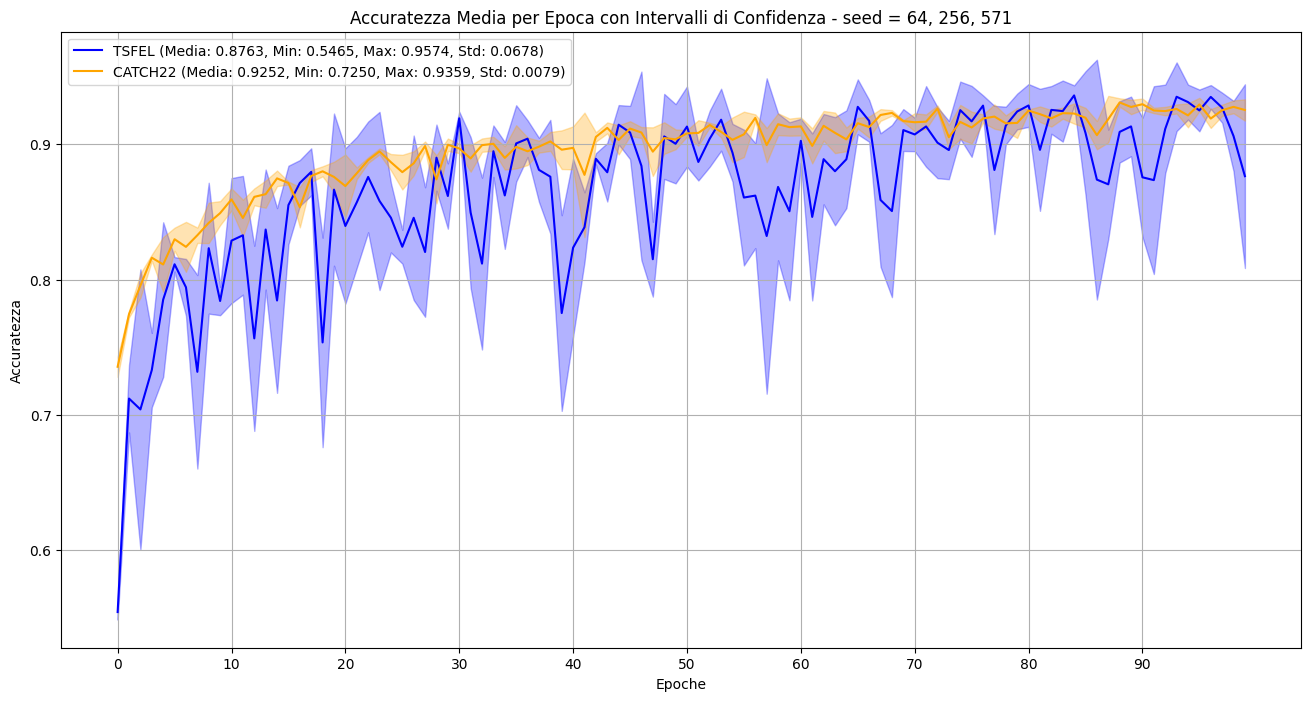

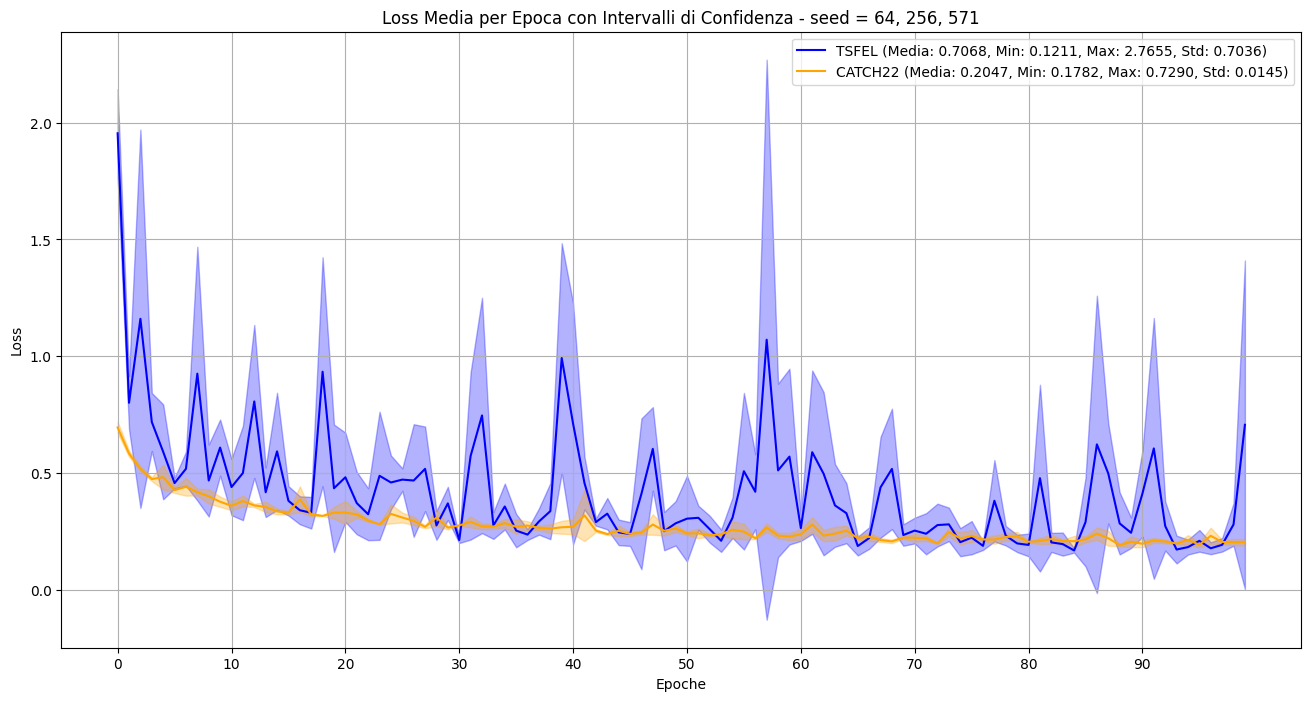

In [43]:
plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche)

In [67]:
tsfel_3d_bal = tsfel_bal.reshape(tsfel_bal.shape[0], 6, 45)
catch22_3d_bal = catch22_bal.reshape(catch22_bal.shape[0], 6, 22)

tsfel_3d_bal = np.expand_dims(tsfel_3d_bal, axis=1)
catch22_3d_bal = np.expand_dims(catch22_3d_bal, axis=1)

print(f"Shape tsfel_3d_bal: {tsfel_3d_bal.shape}")
print(f"Shape catch22_3d_bal: {catch22_3d_bal.shape}")

Shape tsfel_3d_bal: (218802, 1, 6, 45)
Shape catch22_3d_bal: (218802, 1, 6, 22)


In [48]:
acc_tsfel = []
acc_catch22 = []

loss_tsfel = []
loss_catch22 = []

execution_tsfel_times = []
execution_catch22_times = []

for seed in seeds:
    print(f"Seed: {seed}")
    
    model_tsfel = SimpleCNN2D(channels=tsfel_3d_bal.shape[2], features=tsfel_3d_bal.shape[3], num_classes=6)
    model_catch22 = SimpleCNN2D(channels=catch22_3d_bal.shape[2], features=catch22_3d_bal.shape[3], num_classes=6)

    train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel_3d_bal, y_bal, batch_size, seed)
    optimizer = optim.Adam(model_tsfel.parameters(), lr=lr)

    startT = time.time()
    acc_vec_tsfel, loss_vec_tsfel, cnn_tsfel_2_bal = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer, n_epoche)
    execution_tsfel_times.append(time.time() - startT)

    acc_tsfel.append(acc_vec_tsfel)
    loss_tsfel.append(loss_vec_tsfel)

    train_loader_catch22, val_loader_catch22 = loaders_maker(catch22_3d_bal, y_bal, batch_size, seed)
    optimizer = optim.Adam(model_catch22.parameters(), lr=lr)

    startT = time.time()
    acc_vec_catch22, loss_vec_catch22, cnn_catch22_2_bal = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer, n_epoche)
    execution_catch22_times.append(time.time() - startT)
    
    acc_catch22.append(acc_vec_catch22)
    loss_catch22.append(loss_vec_catch22)

Seed: 64


Training epochs..: 100%|██████████| 100/100 [06:35<00:00,  3.96s/it]


Tempo totale di addestramento: 395.80 secondi
Tempo di valutazione (predizioni): 0.59 secondi

Accuratezza finale: 0.8902
Accuratezza media: 0.8661
Accuratezza minima: 0.6871, epoca: 1
Accuratezza massima: 0.8928, epoca: 99
Loss finale: 0.3139, epoca: 1
Loss media: 0.3743
Loss minima: 0.3064, epoca: 99
Loss massima: 0.8223, epoca: 1



Training epochs..: 100%|██████████| 100/100 [04:16<00:00,  2.57s/it]


Tempo totale di addestramento: 256.73 secondi
Tempo di valutazione (predizioni): 0.66 secondi

Accuratezza finale: 0.8229
Accuratezza media: 0.7955
Accuratezza minima: 0.5974, epoca: 1
Accuratezza massima: 0.8294, epoca: 98
Loss finale: 0.4858, epoca: 1
Loss media: 0.5491
Loss minima: 0.4722, epoca: 98
Loss massima: 1.0311, epoca: 1

Seed: 256


Training epochs..: 100%|██████████| 100/100 [07:09<00:00,  4.29s/it]


Tempo totale di addestramento: 429.38 secondi
Tempo di valutazione (predizioni): 0.58 secondi

Accuratezza finale: 0.8927
Accuratezza media: 0.8665
Accuratezza minima: 0.6934, epoca: 1
Accuratezza massima: 0.8929, epoca: 97
Loss finale: 0.3085, epoca: 1
Loss media: 0.3753
Loss minima: 0.3064, epoca: 98
Loss massima: 0.8247, epoca: 1



Training epochs..: 100%|██████████| 100/100 [04:06<00:00,  2.47s/it]


Tempo totale di addestramento: 246.85 secondi
Tempo di valutazione (predizioni): 0.64 secondi

Accuratezza finale: 0.8255
Accuratezza media: 0.7948
Accuratezza minima: 0.6017, epoca: 1
Accuratezza massima: 0.8303, epoca: 99
Loss finale: 0.4793, epoca: 1
Loss media: 0.5547
Loss minima: 0.4724, epoca: 99
Loss massima: 1.0304, epoca: 1

Seed: 571


Training epochs..: 100%|██████████| 100/100 [06:55<00:00,  4.16s/it]


Tempo totale di addestramento: 415.87 secondi
Tempo di valutazione (predizioni): 0.59 secondi

Accuratezza finale: 0.8941
Accuratezza media: 0.8677
Accuratezza minima: 0.6845, epoca: 1
Accuratezza massima: 0.8946, epoca: 96
Loss finale: 0.3086, epoca: 1
Loss media: 0.3719
Loss minima: 0.3024, epoca: 96
Loss massima: 0.8354, epoca: 1



Training epochs..: 100%|██████████| 100/100 [04:00<00:00,  2.41s/it]


Tempo totale di addestramento: 240.63 secondi
Tempo di valutazione (predizioni): 0.61 secondi

Accuratezza finale: 0.8327
Accuratezza media: 0.7994
Accuratezza minima: 0.5965, epoca: 1
Accuratezza massima: 0.8334, epoca: 95
Loss finale: 0.4675, epoca: 1
Loss media: 0.5410
Loss minima: 0.4630, epoca: 99
Loss massima: 1.0269, epoca: 1



In [49]:
torch.save(cnn_tsfel_2_bal.state_dict(), "cnn_tsfel_2_bal.pth")
torch.save(cnn_catch22_2_bal.state_dict(), "cnn_catch22_2_bal.pth")

In [50]:
cnn_tsfel_2_bal = SimpleCNN2D(channels=tsfel_3d_bal.shape[2], features=tsfel_3d_bal.shape[3], num_classes=6)
cnn_catch22_2_bal = SimpleCNN2D(channels=catch22_3d_bal.shape[2], features=catch22_3d_bal.shape[3], num_classes=6)
cnn_tsfel_2_bal.load_state_dict(torch.load("cnn_tsfel_2_bal.pth"))
cnn_catch22_2_bal.load_state_dict(torch.load("cnn_catch22_2_bal.pth"))

<All keys matched successfully>

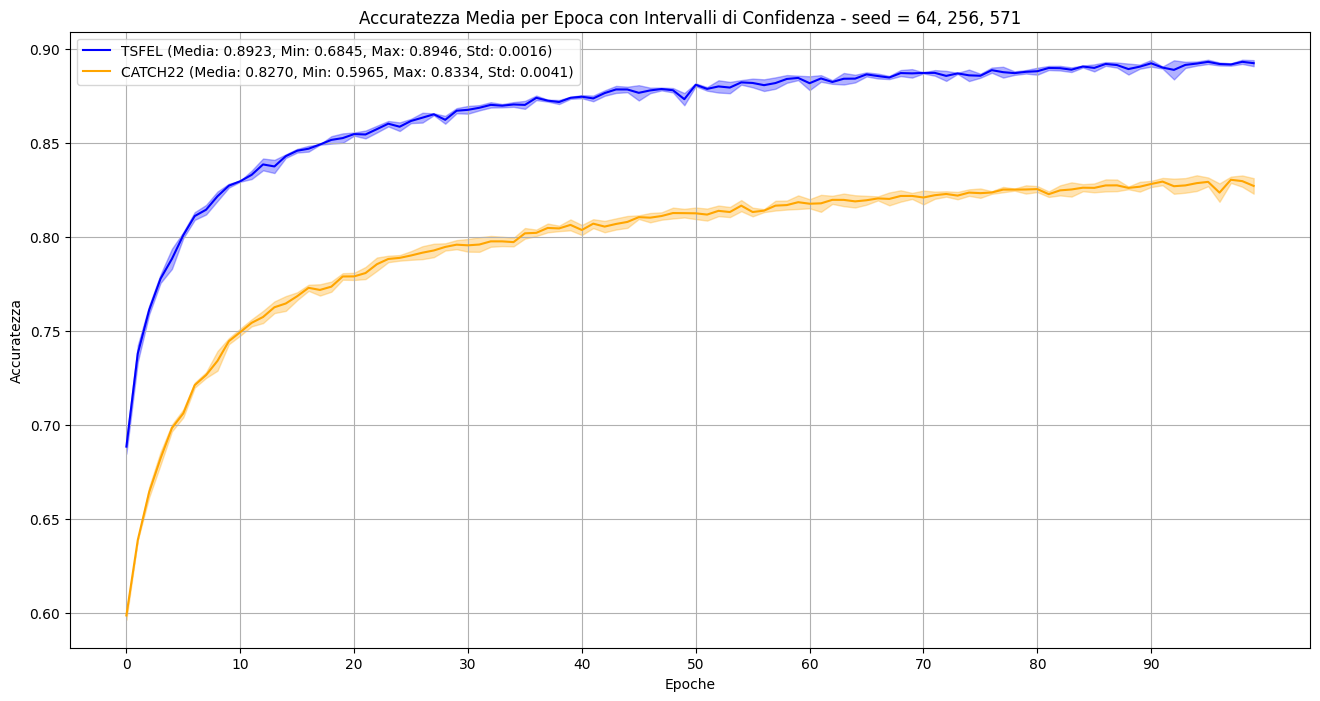

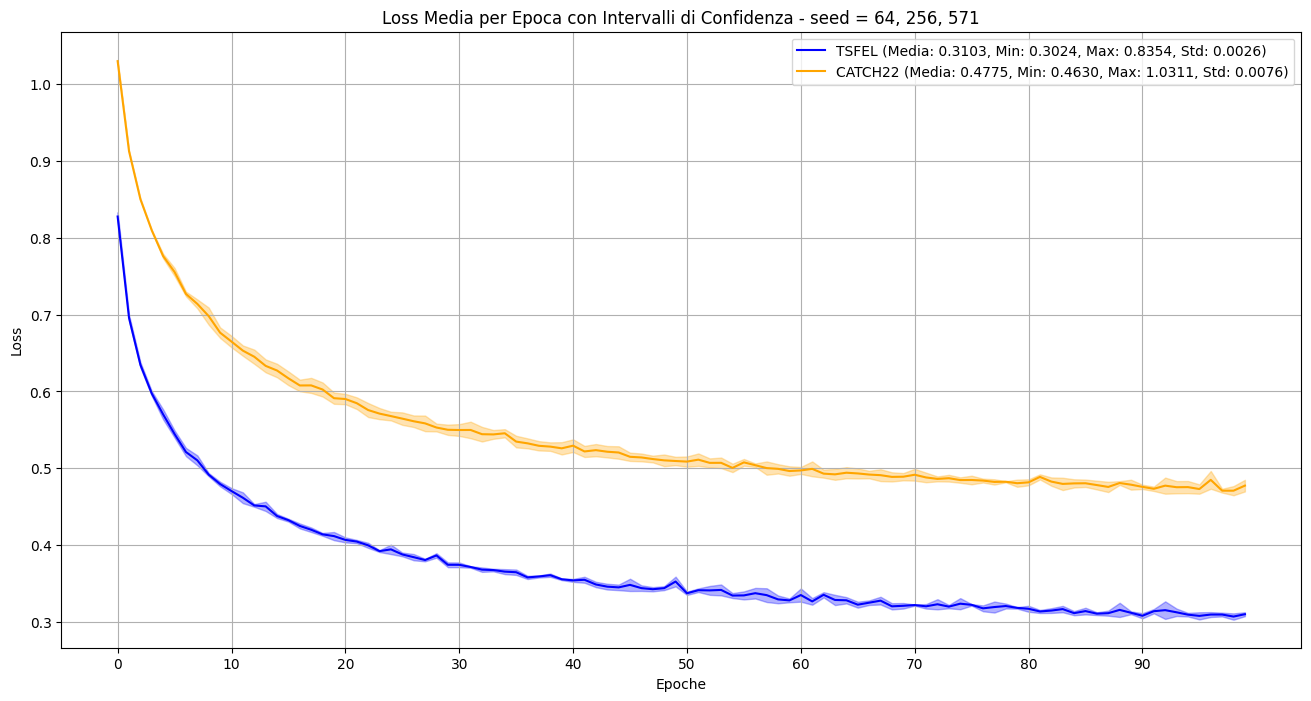

In [51]:
plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche)

In [ ]:
acc_tsfel = []
acc_catch22 = []

loss_tsfel = []
loss_catch22 = []

execution_tsfel_times = []
execution_catch22_times = []

for seed in seeds:
    print(f"Seed: {seed}")
    model_tsfel = SimpleCNN(input_channels=1, sequence_length=tsfel_bal.shape[1], num_classes=6)
    model_catch22 = SimpleCNN(input_channels=1, sequence_length=catch22_bal.shape[1], num_classes=6)

    train_loader_tsfel, val_loader_tsfel = loaders_maker(tsfel_bal.reshape(tsfel_bal.shape[0], 1, tsfel_bal.shape[1]), y_bal, batch_size, seed)
    optimizer = optim.Adam(model_tsfel.parameters(), lr=lr)
    startT = time.time()
    acc_vec_tsfel, loss_vec_tsfel, cnn_tsfel_1_bal = train_model(model_tsfel.to(device), train_loader_tsfel, val_loader_tsfel, criterion, optimizer, n_epoche)
    
    execution_tsfel_times.append(time.time() - startT)
    acc_tsfel.append(acc_vec_tsfel)
    loss_tsfel.append(loss_vec_tsfel)
    
    train_loader_catch22, val_loader_catch22 = loaders_maker(catch22_bal.reshape(catch22_bal.shape[0], 1, catch22_bal.shape[1]), y_bal, batch_size, seed)
    optimizer = optim.Adam(model_catch22.parameters(), lr=lr)
    startT = time.time()
    acc_vec_catch22, loss_vec_catch22, cnn_catch22_1_bal = train_model(model_catch22.to(device), train_loader_catch22, val_loader_catch22, criterion, optimizer, n_epoche)
    
    execution_catch22_times.append(time.time() - startT)
    acc_catch22.append(acc_vec_catch22)
    loss_catch22.append(loss_vec_catch22)

Seed: 64


Training epochs..: 100%|██████████| 100/100 [04:09<00:00,  2.49s/it]


Tempo totale di addestramento: 249.48 secondi
Tempo di valutazione (predizioni): 0.51 secondi

Accuratezza finale: 0.8499
Accuratezza media: 0.8283
Accuratezza minima: 0.6965, epoca: 1
Accuratezza massima: 0.8501, epoca: 96
Loss finale: 0.4191, epoca: 1
Loss media: 0.4768
Loss minima: 0.4191, epoca: 100
Loss massima: 0.8473, epoca: 1



Training epochs..: 100%|██████████| 100/100 [03:28<00:00,  2.09s/it]


Tempo totale di addestramento: 208.83 secondi
Tempo di valutazione (predizioni): 0.35 secondi

Accuratezza finale: 0.7726
Accuratezza media: 0.7444
Accuratezza minima: 0.6019, epoca: 1
Accuratezza massima: 0.7727, epoca: 98
Loss finale: 0.6133, epoca: 1
Loss media: 0.6807
Loss minima: 0.6130, epoca: 98
Loss massima: 1.0536, epoca: 1

Seed: 256


Training epochs..: 100%|██████████| 100/100 [04:14<00:00,  2.54s/it]


Tempo totale di addestramento: 254.25 secondi
Tempo di valutazione (predizioni): 0.51 secondi

Accuratezza finale: 0.8522
Accuratezza media: 0.8298
Accuratezza minima: 0.6969, epoca: 1
Accuratezza massima: 0.8527, epoca: 95
Loss finale: 0.4168, epoca: 1
Loss media: 0.4770
Loss minima: 0.4167, epoca: 98
Loss massima: 0.8485, epoca: 1



Training epochs..: 100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


Tempo totale di addestramento: 187.26 secondi
Tempo di valutazione (predizioni): 0.38 secondi

Accuratezza finale: 0.7760
Accuratezza media: 0.7490
Accuratezza minima: 0.6071, epoca: 1
Accuratezza massima: 0.7776, epoca: 98
Loss finale: 0.6064, epoca: 1
Loss media: 0.6753
Loss minima: 0.6064, epoca: 100
Loss massima: 1.0487, epoca: 1

Seed: 571


Training epochs..: 100%|██████████| 100/100 [04:12<00:00,  2.52s/it]


Tempo totale di addestramento: 252.46 secondi
Tempo di valutazione (predizioni): 0.52 secondi

Accuratezza finale: 0.8542
Accuratezza media: 0.8328
Accuratezza minima: 0.7049, epoca: 1
Accuratezza massima: 0.8550, epoca: 98
Loss finale: 0.4105, epoca: 1
Loss media: 0.4675
Loss minima: 0.4091, epoca: 98
Loss massima: 0.8323, epoca: 1



Training epochs..: 100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


Tempo totale di addestramento: 232.42 secondi
Tempo di valutazione (predizioni): 0.38 secondi

Accuratezza finale: 0.7762
Accuratezza media: 0.7492
Accuratezza minima: 0.6027, epoca: 1
Accuratezza massima: 0.7762, epoca: 100
Loss finale: 0.6003, epoca: 1
Loss media: 0.6690
Loss minima: 0.6003, epoca: 100
Loss massima: 1.0530, epoca: 1



In [53]:
torch.save(cnn_tsfel_1_bal.state_dict(), "cnn_tsfel_1_bal.pth")
torch.save(cnn_catch22_1_bal.state_dict(), "cnn_catch22_1_bal.pth")

In [54]:
cnn_tsfel_1_bal = SimpleCNN(input_channels=1, sequence_length=tsfel_bal.shape[1], num_classes=6)
cnn_catch22_1_bal = SimpleCNN(input_channels=1, sequence_length=catch22_bal.shape[1], num_classes=6)        
cnn_tsfel_1_bal.load_state_dict(torch.load("cnn_tsfel_1_bal.pth"))
cnn_catch22_1_bal.load_state_dict(torch.load("cnn_catch22_1_bal.pth"))

<All keys matched successfully>

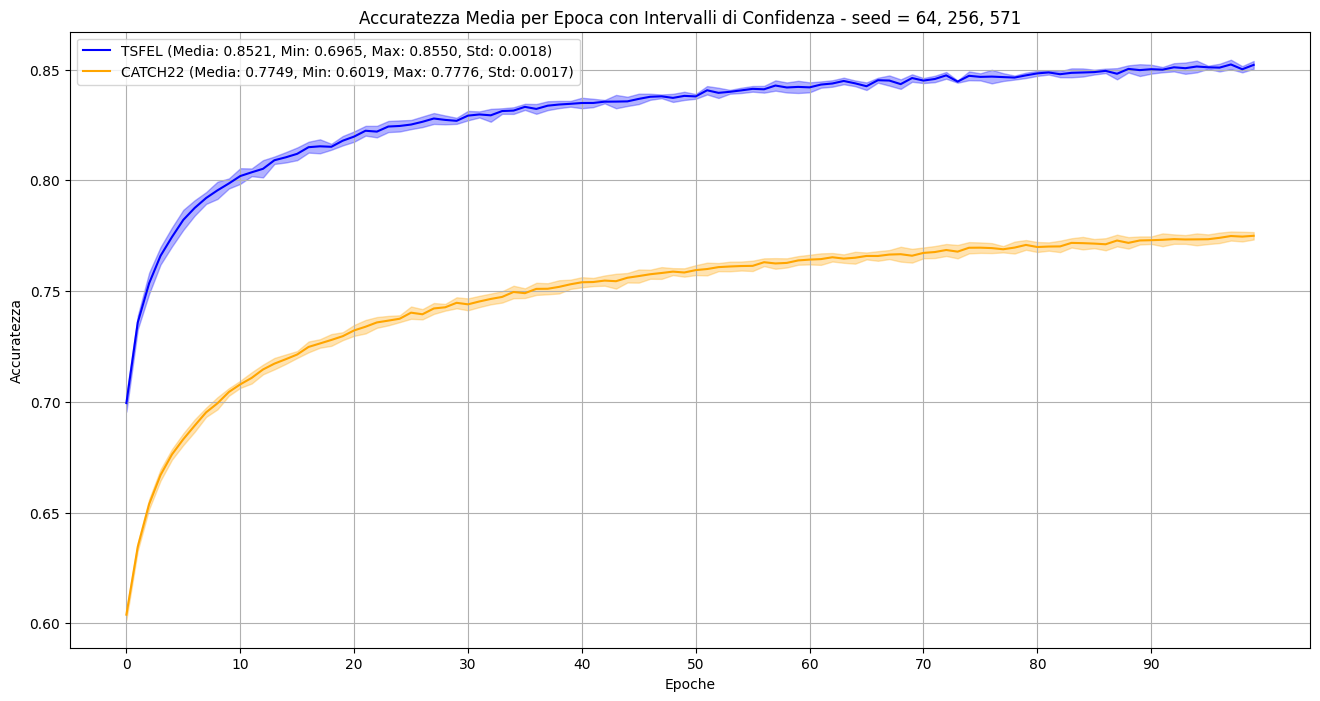

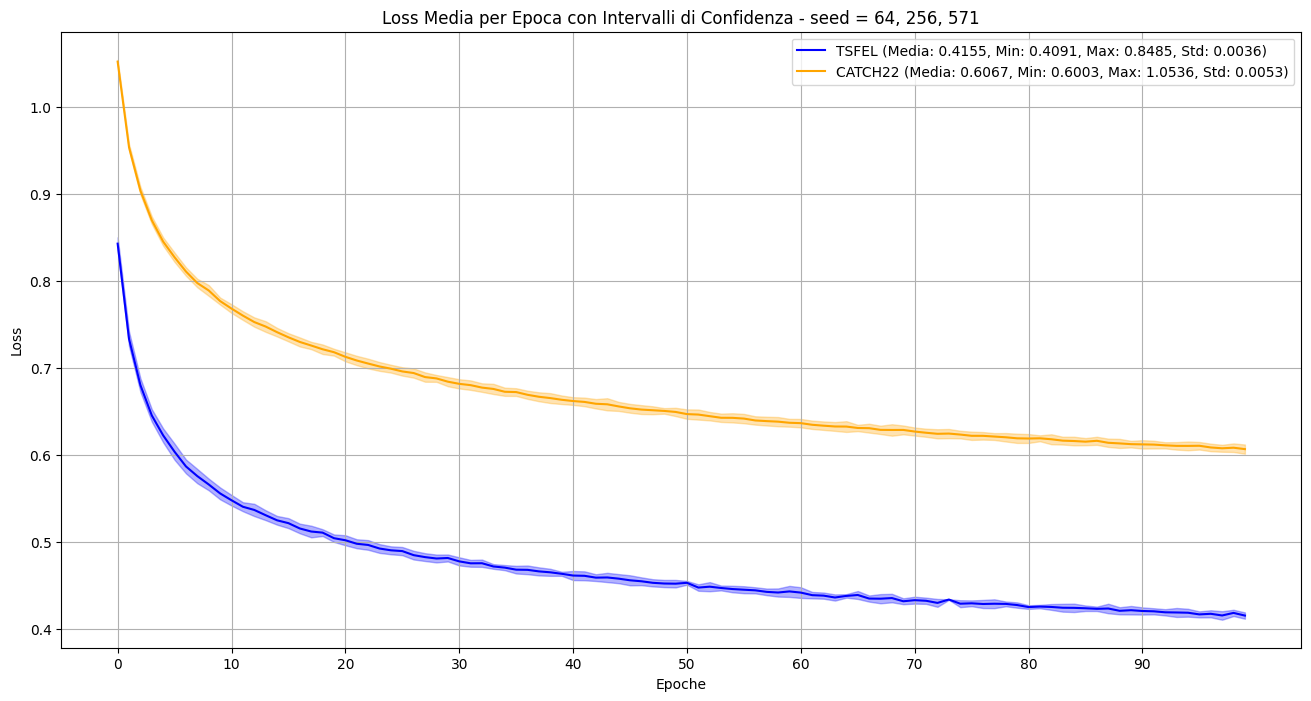

In [55]:
plot_results(acc_tsfel, acc_catch22, loss_tsfel, loss_catch22, n_epoche)

In [12]:
mlp_tsfel_1 = SimpleMLP(input_dim=tsfel.shape[1], num_classes=6)
mlp_catch22_1 = SimpleMLP(input_dim=catch22.shape[1], num_classes=6)

cnn_tsfel_1 = SimpleCNN(input_channels=1, sequence_length=tsfel.shape[1], num_classes=6)
cnn_catch22_1 = SimpleCNN(input_channels=1, sequence_length=catch22.shape[1], num_classes=6)

catch22_3d = np.expand_dims(catch22_3d, axis=1)
tsfel_3d = np.expand_dims(tsfel_3d, axis=1)

cnn_tsfel_2 = SimpleCNN2D(channels=tsfel_3d.shape[2], features=tsfel_3d.shape[3], num_classes=6)
cnn_catch22_2 = SimpleCNN2D(channels=catch22_3d.shape[2], features=catch22_3d.shape[3], num_classes=6)


mlp_tsfel_1.load_state_dict(torch.load("mlp_tsfel_1.pth"))
mlp_catch22_1.load_state_dict(torch.load("mlp_catch22_1.pth"))

cnn_tsfel_1.load_state_dict(torch.load("cnn_tsfel_1.pth"))
cnn_catch22_1.load_state_dict(torch.load("cnn_catch22_1.pth"))

cnn_tsfel_2.load_state_dict(torch.load("cnn_tsfel_2.pth"))
cnn_catch22_2.load_state_dict(torch.load("cnn_catch22_2.pth"))

<All keys matched successfully>

In [ ]:
batch_size = 1024

timeStart = time.time()
conf_mat_tsfel, acc_tsfel = evaluate_model(mlp_tsfel_1.to(device), tsfel, y, device, batch_size)
mlp_tsfel_eval_time = time.time() - timeStart

timeStart = time.time()
conf_mat_catch22, acc_catch22 = evaluate_model(mlp_catch22_1.to(device), catch22, y, device, batch_size)
mlp_catch22_eval_time = time.time() - timeStart


timeStart = time.time()
conf_mat_tsfel_cnn_1, acc_tsfel_cnn_1 = evaluate_model(cnn_tsfel_1.to(device), tsfel.reshape(tsfel.shape[0], 1, tsfel.shape[1]), y, device, batch_size)
cnn_1_tsfel_eval_time = time.time() - timeStart

timeStart = time.time()
conf_mat_catch22_cnn_1, acc_catch22_cnn_1 = evaluate_model(cnn_catch22_1.to(device), catch22.reshape(catch22.shape[0], 1, catch22.shape[1]), y, device, batch_size)
cnn_1_catch22_eval_time = time.time() - timeStart

timeStart = time.time()
conf_mat_tsfel_cnn_2, acc_tsfel_cnn_2 = evaluate_model(cnn_tsfel_2.to(device), tsfel_3d, y_3d, device, batch_size)
cnn_2_tsfel_eval_time = time.time() - timeStart

timeStart = time.time()
conf_mat_catch22_cnn_2, acc_catch22_cnn_2 = evaluate_model(cnn_catch22_2.to(device), catch22_3d, y_3d, device, batch_size)  
cnn_2_catch22_eval_time = time.time() - timeStart

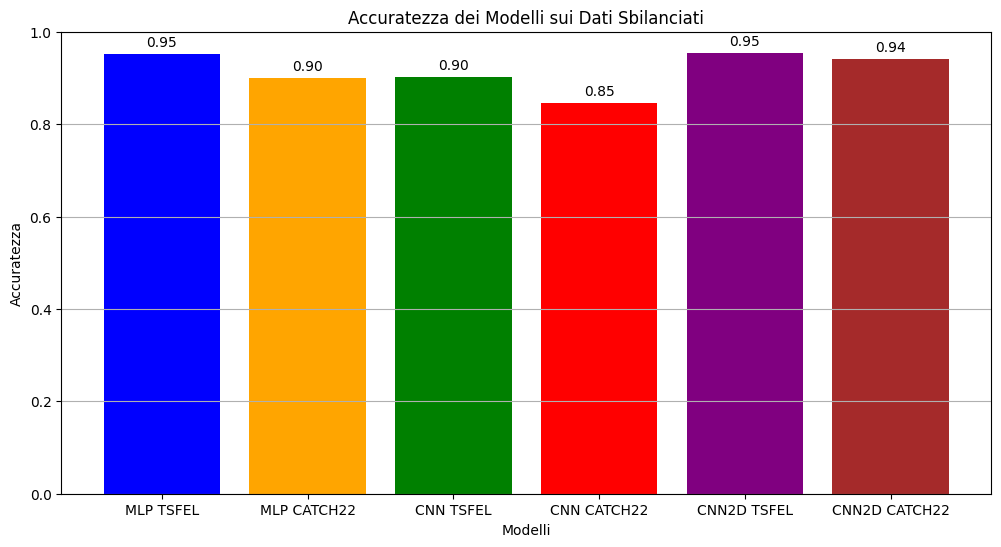

In [ ]:
accuracies = [acc_tsfel, acc_catch22, acc_tsfel_cnn_1, acc_catch22_cnn_1, acc_tsfel_cnn_2, acc_catch22_cnn_2]
labels = ['MLP TSFEL', 'MLP CATCH22', 'CNN TSFEL', 'CNN CATCH22', 'CNN2D TSFEL', 'CNN2D CATCH22']   

plt.figure(figsize=(12, 6))
plt.bar(labels, accuracies, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.title('Accuratezza dei Modelli sui Dati Sbilanciati')   
plt.xlabel('Modelli')
plt.ylabel('Accuratezza')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


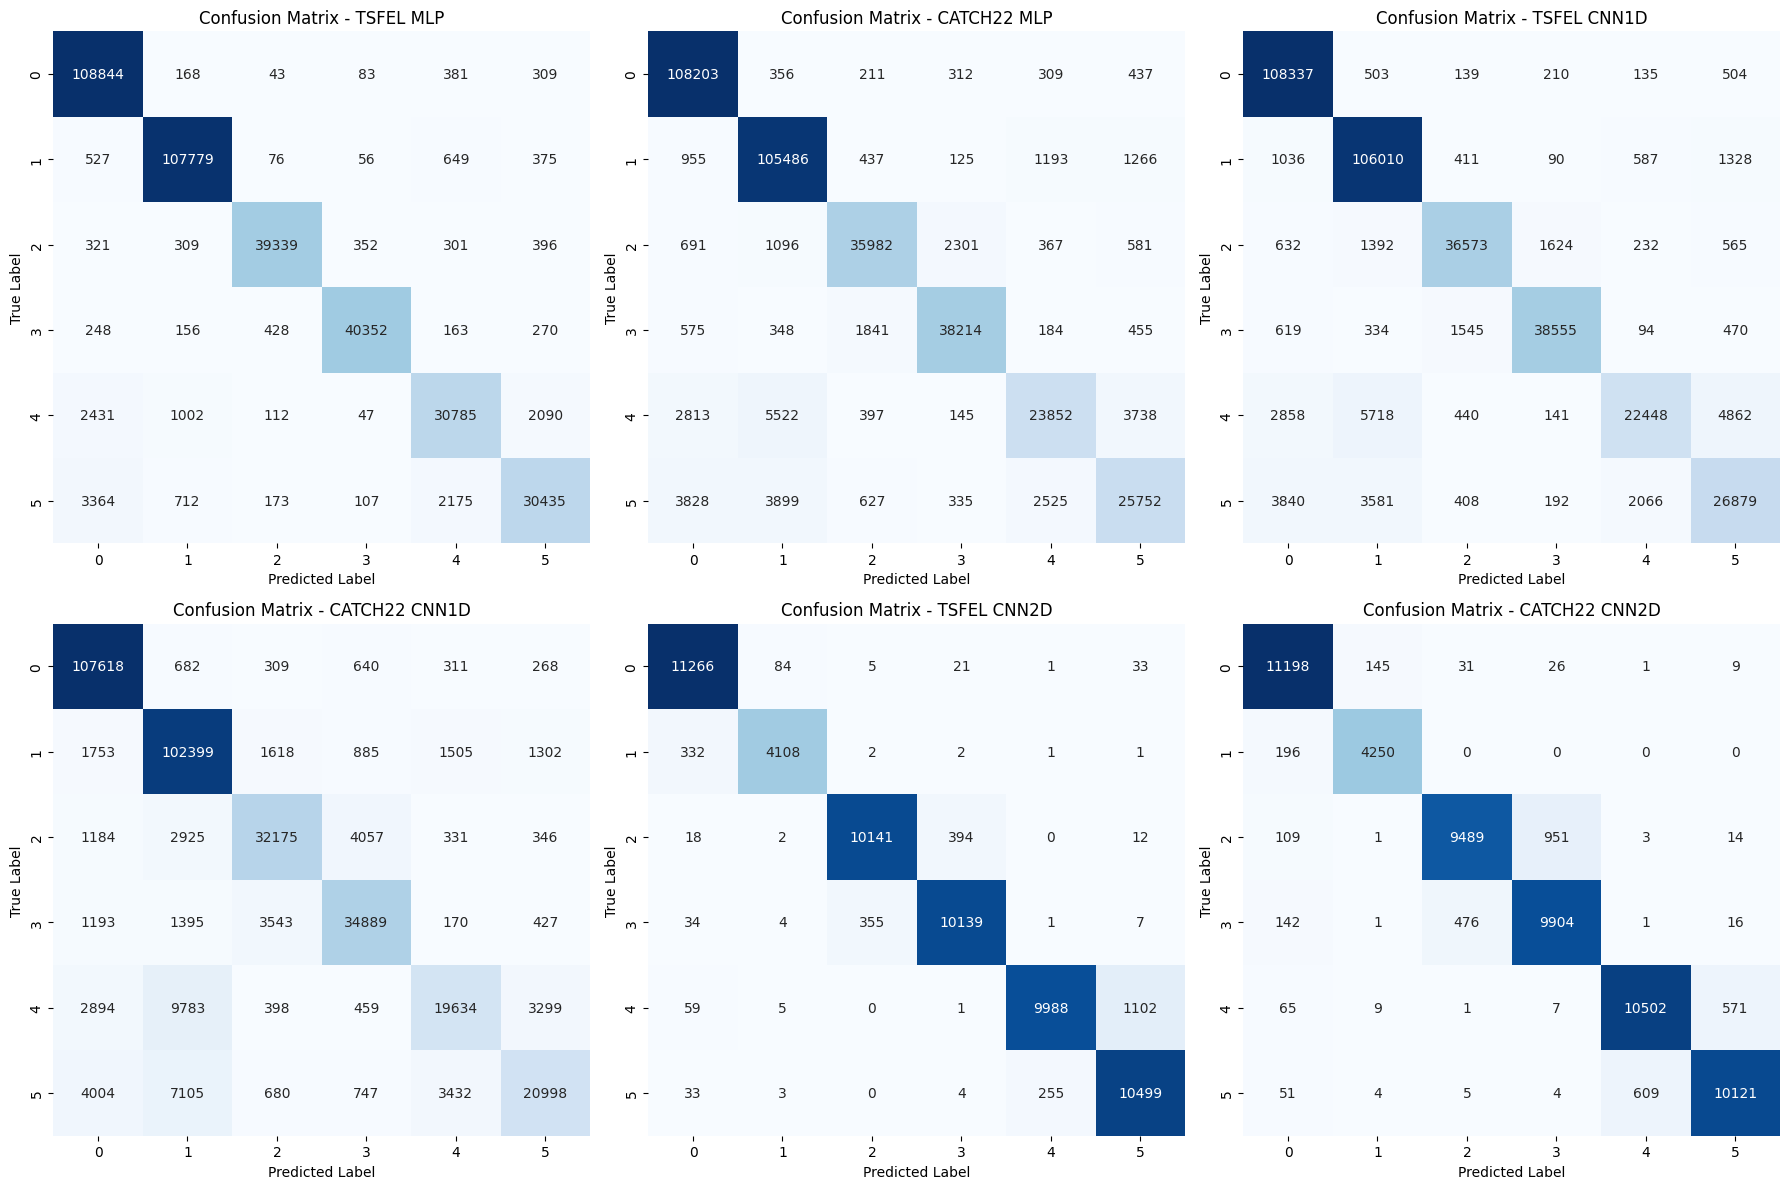

In [ ]:
# 0-Walking, 1-Jogging, 2-DownStairs, 3-UpStairs, 4-Sitting, 5-Standing

labels = ['0', '1', '2', '3', '4', '5']
models = ['TSFEL MLP', 'CATCH22 MLP', 'TSFEL CNN1D', 'CATCH22 CNN1D', 'TSFEL CNN2D', 'CATCH22 CNN2D']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

confusion_matrices = [conf_mat_tsfel, conf_mat_catch22, conf_mat_tsfel_cnn_1, conf_mat_catch22_cnn_1, conf_mat_tsfel_cnn_2, conf_mat_catch22_cnn_2]
for i, ax in enumerate(axes.flat):
    sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix - {models[i]}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

In [31]:
mlp_tsfel_bal = SimpleMLP(input_dim=tsfel_bal.shape[1], num_classes=6)
mlp_cacth22_bal = SimpleMLP(input_dim=catch22_bal.shape[1], num_classes=6)

cnn_tsfel_1_bal = SimpleCNN(input_channels=1, sequence_length=tsfel_bal.shape[1], num_classes=6)
cnn_catch22_1_bal = SimpleCNN(input_channels=1, sequence_length=catch22_bal.shape[1], num_classes=6) 

cnn_tsfel_2_bal = SimpleCNN2D(channels=tsfel_3d_bal.shape[2], features=tsfel_3d_bal.shape[3], num_classes=6)
cnn_catch22_2_bal = SimpleCNN2D(channels=catch22_3d_bal.shape[2], features=catch22_3d_bal.shape[3], num_classes=6)

mlp_tsfel_bal.load_state_dict(torch.load("mlp_tsfel_bal.pth"))
mlp_cacth22_bal.load_state_dict(torch.load("mlp_cacth22_bal.pth"))
cnn_tsfel_1_bal.load_state_dict(torch.load("cnn_tsfel_1_bal.pth"))
cnn_catch22_1_bal.load_state_dict(torch.load("cnn_catch22_1_bal.pth"))
cnn_tsfel_2_bal.load_state_dict(torch.load("cnn_tsfel_2_bal.pth"))
cnn_catch22_2_bal.load_state_dict(torch.load("cnn_catch22_2_bal.pth"))       


<All keys matched successfully>

In [37]:
batch_size = 1024
timeStart = time.time()
conf_mat_tsfel_bal, acc_tsfel_bal = evaluate_model(mlp_tsfel_bal.to(device), tsfel_bal, y_bal, device, batch_size)
mlp_tsfel_bal_eval_time = time.time() - timeStart

timeStart = time.time()
conf_mat_catch22_bal, acc_catch22_bal = evaluate_model(mlp_cacth22_bal.to(device), catch22_bal, y_bal, device, batch_size)
mlp_catch22_bal_eval_time = time.time() - timeStart

timeStart = time.time()
conf_mat_tsfel_cnn_1_bal, acc_tsfel_cnn_1_bal = evaluate_model(cnn_tsfel_1_bal.to(device), tsfel_bal.reshape(tsfel_bal.shape[0], 1, tsfel_bal.shape[1]), y_bal, device, batch_size)
cnn_tsfel_1_bal_eval_time = time.time() - timeStart

timeStart = time.time()
conf_mat_catch22_cnn_1_bal, acc_catch22_cnn_1_bal = evaluate_model(cnn_catch22_1_bal.to(device), catch22_bal.reshape(catch22_bal.shape[0], 1, catch22_bal.shape[1]), y_bal, device, batch_size)
cnn_catch22_1_bal_eval_time = time.time() - timeStart

timeStart = time.time()
conf_mat_tsfel_cnn_2_bal, acc_tsfel_cnn_2_bal = evaluate_model(cnn_tsfel_2_bal.to(device), tsfel_3d_bal, y_bal, device, batch_size)
cnn_tsfel_2_bal_eval_time = time.time() - timeStart

timeStart = time.time()
conf_mat_catch22_cnn_2_bal, acc_catch22_cnn_2_bal = evaluate_model(cnn_catch22_2_bal.to(device), catch22_3d_bal, y_bal, device, batch_size)
cnn_catch22_2_bal_eval_time = time.time() - timeStart

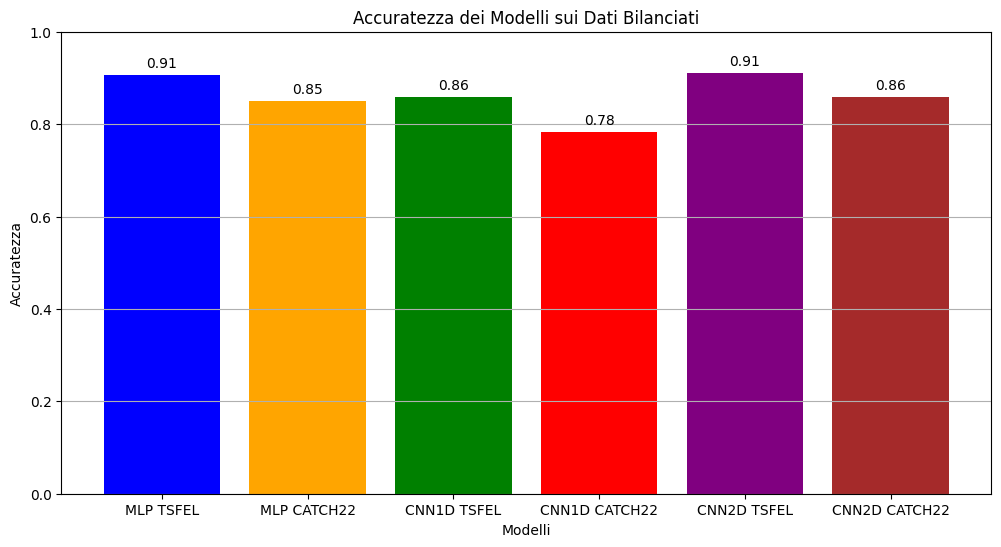

In [36]:
accuracies_bal = [acc_tsfel_bal, acc_catch22_bal, acc_tsfel_cnn_1_bal, acc_catch22_cnn_1_bal, acc_tsfel_cnn_2_bal, acc_catch22_cnn_2_bal]
labels_bal = ['MLP TSFEL', 'MLP CATCH22', 'CNN1D TSFEL', 'CNN1D CATCH22', 'CNN2D TSFEL', 'CNN2D CATCH22'] 
plt.figure(figsize=(12, 6))
plt.bar(labels_bal, accuracies_bal, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.title('Accuratezza dei Modelli sui Dati Bilanciati')
plt.xlabel('Modelli')
plt.ylabel('Accuratezza')
for i, acc in enumerate(accuracies_bal):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

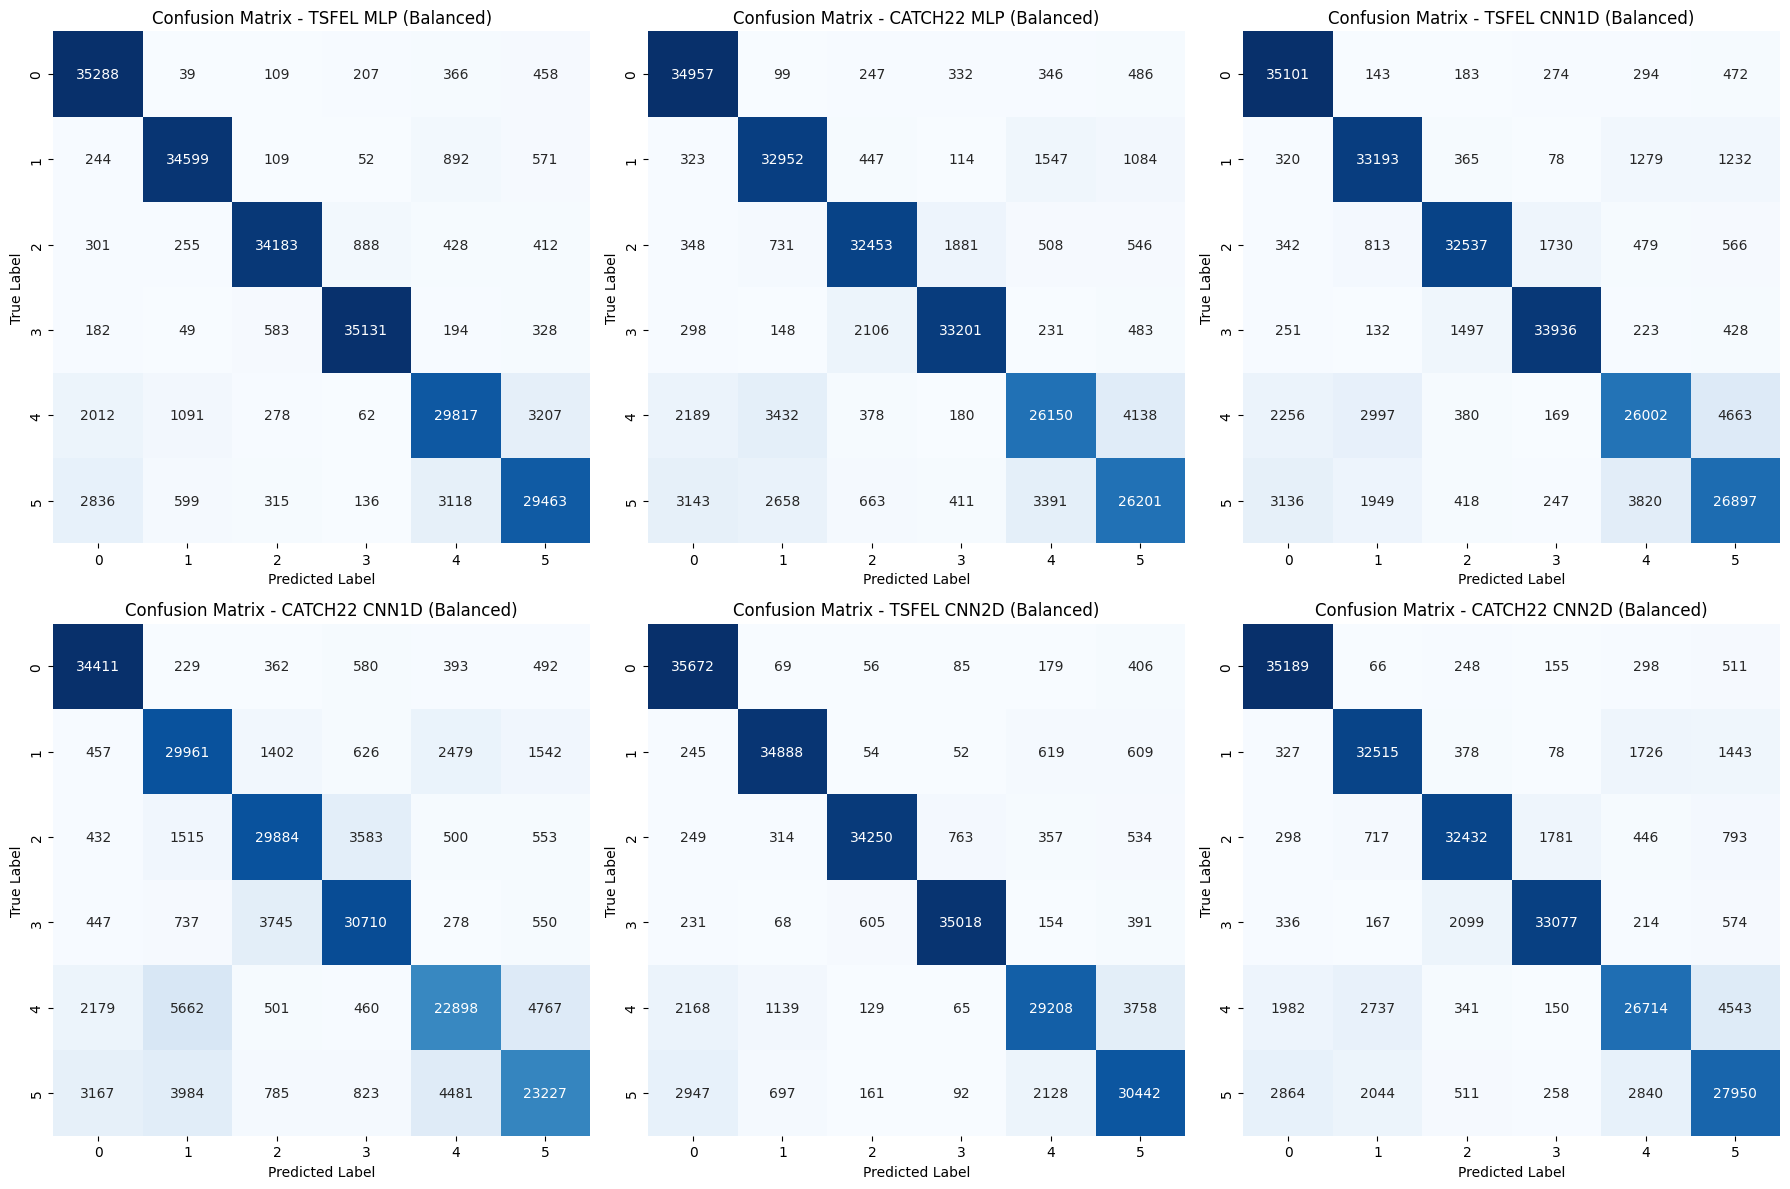

In [33]:
labels = ['0', '1', '2', '3', '4', '5']
models = ['TSFEL MLP', 'CATCH22 MLP', 'TSFEL CNN1D', 'CATCH22 CNN1D', 'TSFEL CNN2D', 'CATCH22 CNN2D']
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

confusion_matrices_bal = [conf_mat_tsfel_bal, conf_mat_catch22_bal, conf_mat_tsfel_cnn_1_bal, conf_mat_catch22_cnn_1_bal, conf_mat_tsfel_cnn_2_bal, conf_mat_catch22_cnn_2_bal]
for i, ax in enumerate(axes.flat):
    sns.heatmap(confusion_matrices_bal[i], annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'Confusion Matrix - {models[i]} (Balanced)')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label') 
plt.tight_layout()
plt.show()

In [ ]:
data = {
    'Model': ['MLP TSFEL', 'MLP CATCH22', 'CNN1D TSFEL', 'CNN1D CATCH22', 'CNN2D TSFEL', 'CNN2D CATCH22'],
    'Accuracy (Sbilanciato)': [acc_tsfel, acc_catch22, acc_tsfel_cnn_1, acc_catch22_cnn_1, acc_tsfel_cnn_2, acc_catch22_cnn_2],
    'Execution Time (Sbilanciato)': [mlp_tsfel_eval_time, mlp_catch22_eval_time, cnn_1_tsfel_eval_time, cnn_1_catch22_eval_time, cnn_2_tsfel_eval_time, cnn_2_catch22_eval_time],
    'Accuracy (Bilanciato)': [acc_tsfel_bal, acc_catch22_bal, acc_tsfel_cnn_1_bal, acc_catch22_cnn_1_bal, acc_tsfel_cnn_2_bal, acc_catch22_cnn_2_bal],
    'Execution Time (Bilanciato)': [mlp_tsfel_bal_eval_time, mlp_catch22_bal_eval_time, cnn_tsfel_1_bal_eval_time, cnn_catch22_1_bal_eval_time, cnn_tsfel_2_bal_eval_time, cnn_catch22_2_bal_eval_time]
}

df = pd.DataFrame(data)
df['Accuracy (Sbilanciato)'] = df['Accuracy (Sbilanciato)'].apply(lambda x: f"{x:.2f}")
df['Accuracy (Bilanciato)'] = df['Accuracy (Bilanciato)'].apply(lambda x: f"{x:.2f}")
df['Execution Time (Sbilanciato)'] = df['Execution Time (Sbilanciato)'].apply(lambda x: f"{x:.2f} s")
df['Execution Time (Bilanciato)'] = df['Execution Time (Bilanciato)'].apply(lambda x: f"{x:.2f} s") 
df = df.set_index('Model')
print(df)

              Accuracy (Sbilanciato) Execution Time (Sbilanciato)  \
Model                                                               
MLP TSFEL                       0.95                       3.38 s   
MLP CATCH22                     0.90                       3.40 s   
CNN1D TSFEL                     0.90                       4.60 s   
CNN1D CATCH22                   0.85                       3.37 s   
CNN2D TSFEL                     0.95                       1.09 s   
CNN2D CATCH22                   0.94                       0.60 s   

              Accuracy (Bilanciato) Execution Time (Bilanciato)  
Model                                                            
MLP TSFEL                      0.91                      2.17 s  
MLP CATCH22                    0.85                      1.72 s  
CNN1D TSFEL                    0.86                      2.75 s  
CNN1D CATCH22                  0.78                      2.07 s  
CNN2D TSFEL                    0.91                

In [ ]:
count_params_mlp_tsfel_bal = sum(p.numel() for p in mlp_tsfel_bal.parameters() if p.requires_grad)
count_params_cnn2d_tsfel_bal = sum(p.numel() for p in cnn_tsfel_2_bal.parameters() if p.requires_grad)

size_mlp_tsfel_bal = estimate_model_size(mlp_tsfel_bal)
size_cnn2d_tsfel_bal = estimate_model_size(cnn_tsfel_2_bal)

In [53]:
print(f"Numero di parametri MLP TSFEL bilanciato: {count_params_mlp_tsfel_bal}")
print(f"Numero di parametri CNN2D TSFEL bilanciato: {count_params_cnn2d_tsfel_bal}")
print(f"Dimensione MLP TSFEL bilanciato: {size_mlp_tsfel_bal:.4f} MB")
print(f"Dimensione CNN2D TSFEL bilanciato: {size_cnn2d_tsfel_bal:.4f} MB")

Numero di parametri MLP TSFEL bilanciato: 86214
Numero di parametri CNN2D TSFEL bilanciato: 560390
Dimensione MLP TSFEL bilanciato: 0.3289 MB
Dimensione CNN2D TSFEL bilanciato: 2.1377 MB


In [54]:
input_shape_3d = (1,tsfel_3d_bal[1], tsfel_3d_bal[2])  # Per CNN 2D
input_shape = (1, tsfel_bal.shape[1])  # Per MLP e CNN 1D
total_mem_mlp = estimate_total_inference_memory(mlp_tsfel_bal, input_shape, quantized=False, activation_factor=1.5)
total_mem_cnn   = estimate_total_inference_memory(cnn_tsfel_2_bal, input_shape, quantized=False, activation_factor=1.5)

print("Memoria totale stimata MLP: {:.4f} MB".format(total_mem_mlp))
print("Memoria totale stimata CNN2D: {:.4f} MB".format(total_mem_cnn))

Memoria totale stimata MLP: 0.3304 MB
Memoria totale stimata CNN2D: 2.1393 MB


In [ ]:
param_grid = {
    'lr': [1e-3, 1e-4, 1e-5],
    'n_epoche': [300],
    'batch_size': [512, 1024, 2048]
}

criterion = nn.CrossEntropyLoss()
seed = 42

results = {"SimpleMLP": [], "SimpleCNN2D": []}

# Grid search
for lr in param_grid['lr']:
    for n_epoche in param_grid['n_epoche']:
        for batch_size in param_grid['batch_size']:
            params = {'lr': lr, 'n_epoche': n_epoche, 'batch_size': batch_size}
            print("Testo con parametri:", params)
            
            # MLP 
            print("Inizio addestramento MLP...")
            train_loader, val_loader = loaders_maker(tsfel_bal, y_bal, batch_size, seed)
            model_mlp = SimpleMLP(input_dim=tsfel_bal.shape[1], num_classes=6)
            optimizer = optim.Adam(model_mlp.parameters(), lr=lr)
            acc_vec, loss_vec, best_model = train_model(model_mlp.to(device), train_loader, val_loader, criterion, optimizer, n_epoche)
            stats = {
                'min_acc': np.min(acc_vec),
                'max_acc': np.max(acc_vec),
                'min_loss': np.min(loss_vec),
                'max_loss': np.max(loss_vec)
            }
            results["SimpleMLP"].append({
                'params': params,
                'acc_vec': acc_vec,
                'loss_vec': loss_vec,
                'stats': stats,
                'best_model': best_model
            })
            
            # CNN2D
            print("Inizio addestramento CNN2D...")
            train_loader, val_loader = loaders_maker(tsfel_3d_bal, y_bal, batch_size, seed)
            model_cnn2d = SimpleCNN2D(channels=tsfel_3d_bal.shape[2], features=tsfel_3d_bal.shape[3], num_classes=6)
            optimizer = optim.Adam(model_cnn2d.parameters(), lr=lr)
            acc_vec, loss_vec, best_model = train_model(model_cnn2d.to(device), train_loader, val_loader, criterion, optimizer, n_epoche)
            stats = {
                'min_acc': np.min(acc_vec),
                'max_acc': np.max(acc_vec),
                'min_loss': np.min(loss_vec),
                'max_loss': np.max(loss_vec)
            }
            results["SimpleCNN2D"].append({
                'params': params,
                'acc_vec': acc_vec,
                'loss_vec': loss_vec,
                'stats': stats,
                'best_model': best_model
            })

Testo con parametri: {'lr': 0.001, 'n_epoche': 300, 'batch_size': 512}
Inizio addestramento MLP...


Training epochs..: 100%|██████████| 300/300 [11:31<00:00,  2.30s/it]


Tempo totale di addestramento: 691.06 secondi
Tempo di valutazione (predizioni): 0.39 secondi

Accuratezza finale: 0.8878
Accuratezza media: 0.8919
Accuratezza minima: 0.8181, epoca: 1
Accuratezza massima: 0.9000, epoca: 58
Loss finale: 0.7958, epoca: 288
Loss media: 0.5245
Loss minima: 0.3020, epoca: 22
Loss massima: 0.8412, epoca: 288

Inizio addestramento CNN2D...


Training epochs..: 100%|██████████| 300/300 [20:39<00:00,  4.13s/it]


Tempo totale di addestramento: 1239.86 secondi
Tempo di valutazione (predizioni): 0.61 secondi

Accuratezza finale: 0.8935
Accuratezza media: 0.8918
Accuratezza minima: 0.8112, epoca: 1
Accuratezza massima: 0.8998, epoca: 21
Loss finale: 1.7401, epoca: 294
Loss media: 1.2131
Loss minima: 0.2968, epoca: 12
Loss massima: 1.8474, epoca: 294

Testo con parametri: {'lr': 0.001, 'n_epoche': 300, 'batch_size': 1024}
Inizio addestramento MLP...


Training epochs..: 100%|██████████| 300/300 [11:59<00:00,  2.40s/it]


Tempo totale di addestramento: 719.12 secondi
Tempo di valutazione (predizioni): 0.41 secondi

Accuratezza finale: 0.8892
Accuratezza media: 0.8915
Accuratezza minima: 0.7998, epoca: 1
Accuratezza massima: 0.8992, epoca: 109
Loss finale: 0.6820, epoca: 300
Loss media: 0.4563
Loss minima: 0.3052, epoca: 37
Loss massima: 0.6820, epoca: 300

Inizio addestramento CNN2D...


Training epochs..: 100%|██████████| 300/300 [19:36<00:00,  3.92s/it]


Tempo totale di addestramento: 1176.74 secondi
Tempo di valutazione (predizioni): 0.59 secondi

Accuratezza finale: 0.8885
Accuratezza media: 0.8900
Accuratezza minima: 0.7885, epoca: 1
Accuratezza massima: 0.8998, epoca: 37
Loss finale: 1.4503, epoca: 269
Loss media: 0.9720
Loss minima: 0.3088, epoca: 22
Loss massima: 1.5391, epoca: 269

Testo con parametri: {'lr': 0.001, 'n_epoche': 300, 'batch_size': 2048}
Inizio addestramento MLP...


Training epochs..: 100%|██████████| 300/300 [12:39<00:00,  2.53s/it]


Tempo totale di addestramento: 759.14 secondi
Tempo di valutazione (predizioni): 0.68 secondi

Accuratezza finale: 0.8933
Accuratezza media: 0.8912
Accuratezza minima: 0.7550, epoca: 1
Accuratezza massima: 0.9001, epoca: 105
Loss finale: 0.5079, epoca: 1
Loss media: 0.3961
Loss minima: 0.3025, epoca: 41
Loss massima: 0.6539, epoca: 1

Inizio addestramento CNN2D...


Training epochs..: 100%|██████████| 300/300 [20:36<00:00,  4.12s/it]


Tempo totale di addestramento: 1236.88 secondi
Tempo di valutazione (predizioni): 0.81 secondi

Accuratezza finale: 0.8932
Accuratezza media: 0.8878
Accuratezza minima: 0.7363, epoca: 1
Accuratezza massima: 0.8975, epoca: 80
Loss finale: 1.0898, epoca: 291
Loss media: 0.6761
Loss minima: 0.3072, epoca: 31
Loss massima: 1.1917, epoca: 291

Testo con parametri: {'lr': 0.0001, 'n_epoche': 300, 'batch_size': 512}
Inizio addestramento MLP...


Training epochs..: 100%|██████████| 300/300 [11:37<00:00,  2.32s/it]


Tempo totale di addestramento: 697.48 secondi
Tempo di valutazione (predizioni): 0.35 secondi

Accuratezza finale: 0.8983
Accuratezza media: 0.8901
Accuratezza minima: 0.6911, epoca: 1
Accuratezza massima: 0.9006, epoca: 166
Loss finale: 0.3314, epoca: 1
Loss media: 0.3261
Loss minima: 0.2978, epoca: 132
Loss massima: 0.8285, epoca: 1

Inizio addestramento CNN2D...


Training epochs..: 100%|██████████| 300/300 [25:07<00:00,  5.03s/it]


Tempo totale di addestramento: 1507.66 secondi
Tempo di valutazione (predizioni): 0.96 secondi

Accuratezza finale: 0.8942
Accuratezza media: 0.8883
Accuratezza minima: 0.7254, epoca: 1
Accuratezza massima: 0.8995, epoca: 122
Loss finale: 0.4938, epoca: 1
Loss media: 0.3762
Loss minima: 0.3015, epoca: 87
Loss massima: 0.7260, epoca: 1

Testo con parametri: {'lr': 0.0001, 'n_epoche': 300, 'batch_size': 1024}
Inizio addestramento MLP...


Training epochs..: 100%|██████████| 300/300 [11:31<00:00,  2.30s/it]


Tempo totale di addestramento: 691.06 secondi
Tempo di valutazione (predizioni): 0.32 secondi

Accuratezza finale: 0.8974
Accuratezza media: 0.8844
Accuratezza minima: 0.6127, epoca: 1
Accuratezza massima: 0.8982, epoca: 269
Loss finale: 0.3180, epoca: 1
Loss media: 0.3362
Loss minima: 0.3064, epoca: 185
Loss massima: 1.0357, epoca: 1

Inizio addestramento CNN2D...


Training epochs..: 100%|██████████| 300/300 [25:26<00:00,  5.09s/it]


Tempo totale di addestramento: 1526.01 secondi
Tempo di valutazione (predizioni): 0.70 secondi

Accuratezza finale: 0.8969
Accuratezza media: 0.8837
Accuratezza minima: 0.6821, epoca: 1
Accuratezza massima: 0.8990, epoca: 229
Loss finale: 0.3488, epoca: 1
Loss media: 0.3397
Loss minima: 0.3001, epoca: 166
Loss massima: 0.8454, epoca: 1

Testo con parametri: {'lr': 0.0001, 'n_epoche': 300, 'batch_size': 2048}
Inizio addestramento MLP...


Training epochs..: 100%|██████████| 300/300 [10:59<00:00,  2.20s/it]


Tempo totale di addestramento: 659.51 secondi
Tempo di valutazione (predizioni): 0.66 secondi

Accuratezza finale: 0.8969
Accuratezza media: 0.8787
Accuratezza minima: 0.5638, epoca: 1
Accuratezza massima: 0.8987, epoca: 295
Loss finale: 0.3041, epoca: 1
Loss media: 0.3446
Loss minima: 0.2996, epoca: 245
Loss massima: 1.3055, epoca: 1

Inizio addestramento CNN2D...


Training epochs..: 100%|██████████| 300/300 [27:24<00:00,  5.48s/it]


Tempo totale di addestramento: 1644.17 secondi
Tempo di valutazione (predizioni): 0.95 secondi

Accuratezza finale: 0.8942
Accuratezza media: 0.8774
Accuratezza minima: 0.6308, epoca: 1
Accuratezza massima: 0.8970, epoca: 272
Loss finale: 0.3112, epoca: 1
Loss media: 0.3473
Loss minima: 0.3020, epoca: 255
Loss massima: 0.9692, epoca: 1

Testo con parametri: {'lr': 1e-05, 'n_epoche': 300, 'batch_size': 512}
Inizio addestramento MLP...


Training epochs..: 100%|██████████| 300/300 [12:28<00:00,  2.50s/it]


Tempo totale di addestramento: 748.54 secondi
Tempo di valutazione (predizioni): 0.35 secondi

Accuratezza finale: 0.8754
Accuratezza media: 0.8354
Accuratezza minima: 0.4348, epoca: 1
Accuratezza massima: 0.8754, epoca: 300
Loss finale: 0.3534, epoca: 1
Loss media: 0.4571
Loss minima: 0.3534, epoca: 300
Loss massima: 1.5932, epoca: 1

Inizio addestramento CNN2D...


Training epochs..: 100%|██████████| 300/300 [26:49<00:00,  5.37s/it]


Tempo totale di addestramento: 1609.74 secondi
Tempo di valutazione (predizioni): 0.74 secondi

Accuratezza finale: 0.8846
Accuratezza media: 0.8523
Accuratezza minima: 0.5629, epoca: 1
Accuratezza massima: 0.8851, epoca: 290
Loss finale: 0.3263, epoca: 1
Loss media: 0.4107
Loss minima: 0.3262, epoca: 299
Loss massima: 1.2657, epoca: 1

Testo con parametri: {'lr': 1e-05, 'n_epoche': 300, 'batch_size': 1024}
Inizio addestramento MLP...


Training epochs..: 100%|██████████| 300/300 [12:02<00:00,  2.41s/it]


Tempo totale di addestramento: 722.69 secondi
Tempo di valutazione (predizioni): 0.51 secondi

Accuratezza finale: 0.8662
Accuratezza media: 0.8159
Accuratezza minima: 0.3650, epoca: 1
Accuratezza massima: 0.8662, epoca: 300
Loss finale: 0.3785, epoca: 1
Loss media: 0.5075
Loss minima: 0.3785, epoca: 300
Loss massima: 1.6793, epoca: 1

Inizio addestramento CNN2D...


Training epochs..: 100%|██████████| 300/300 [26:55<00:00,  5.38s/it]


Tempo totale di addestramento: 1615.48 secondi
Tempo di valutazione (predizioni): 0.87 secondi

Accuratezza finale: 0.8774
Accuratezza media: 0.8407
Accuratezza minima: 0.5153, epoca: 1
Accuratezza massima: 0.8781, epoca: 299
Loss finale: 0.3445, epoca: 1
Loss media: 0.4411
Loss minima: 0.3437, epoca: 299
Loss massima: 1.4664, epoca: 1

Testo con parametri: {'lr': 1e-05, 'n_epoche': 300, 'batch_size': 2048}
Inizio addestramento MLP...


Training epochs..: 100%|██████████| 300/300 [12:04<00:00,  2.41s/it]


Tempo totale di addestramento: 724.24 secondi
Tempo di valutazione (predizioni): 0.70 secondi

Accuratezza finale: 0.8520
Accuratezza media: 0.7894
Accuratezza minima: 0.3464, epoca: 1
Accuratezza massima: 0.8520, epoca: 300
Loss finale: 0.4164, epoca: 1
Loss media: 0.5838
Loss minima: 0.4164, epoca: 300
Loss massima: 1.7425, epoca: 1

Inizio addestramento CNN2D...


Training epochs..: 100%|██████████| 300/300 [29:20<00:00,  5.87s/it]


Tempo totale di addestramento: 1760.39 secondi
Tempo di valutazione (predizioni): 0.96 secondi

Accuratezza finale: 0.8644
Accuratezza media: 0.8218
Accuratezza minima: 0.4833, epoca: 1
Accuratezza massima: 0.8646, epoca: 298
Loss finale: 0.3781, epoca: 1
Loss media: 0.4946
Loss minima: 0.3781, epoca: 300
Loss massima: 1.6132, epoca: 1



In [69]:
# Seleziona il miglior modello per ogni architettura in base alla loss finale
best_mlp = min(results["SimpleMLP"], key=lambda x: x['loss_vec'][-1])
best_cnn2d = min(results["SimpleCNN2D"], key=lambda x: x['loss_vec'][-1])

print("\nMigliori iperparametri per SimpleMLP:")
print(best_mlp['params'])
print("Statistiche MLP: Acc min {:.4f}, Acc max {:.4f}, Loss min {:.4f}, Loss max {:.4f}".format(
    best_mlp['stats']['min_acc'], best_mlp['stats']['max_acc'],
    best_mlp['stats']['min_loss'], best_mlp['stats']['max_loss']
))

print("\nMigliori iperparametri per SimpleCNN2D:")
print(best_cnn2d['params'])
print("Statistiche CNN2D: Acc min {:.4f}, Acc max {:.4f}, Loss min {:.4f}, Loss max {:.4f}".format(
    best_cnn2d['stats']['min_acc'], best_cnn2d['stats']['max_acc'],
    best_cnn2d['stats']['min_loss'], best_cnn2d['stats']['max_loss']
))


Migliori iperparametri per SimpleMLP:
{'lr': 0.0001, 'n_epoche': 300, 'batch_size': 2048}
Statistiche MLP: Acc min 0.5638, Acc max 0.8987, Loss min 0.2996, Loss max 1.3055

Migliori iperparametri per SimpleCNN2D:
{'lr': 0.0001, 'n_epoche': 300, 'batch_size': 2048}
Statistiche CNN2D: Acc min 0.6308, Acc max 0.8970, Loss min 0.3020, Loss max 0.9692


In [ ]:
torch.save(best_mlp['best_model'].state_dict(), "best_mlp_model.pth")
torch.save(best_cnn2d['best_model'].state_dict(), "best_cnn2d_model.pth")

In [ ]:
confusion_mat_mlp, acc_mlp, all_preds_mlp, all_labels_mlp = evaluate_model(best_mlp['best_model'].to(device), tsfel_bal, y_bal, device, batch_size)
print(f"Accuratezza MLP: {acc_mlp:.4f}")

confusion_mat_cnn2d, acc_cnn2d, all_preds_cnn2d, all_labels_cnn2d = evaluate_model(best_cnn2d['best_model'].to(device), tsfel_3d_bal, y_bal, device, batch_size)
print(f"Accuratezza CNN2D: {acc_cnn2d:.4f}")

precision_mlp, recall_mlp, f1_mlp, _ = precision_recall_fscore_support(all_labels_mlp, all_preds_mlp, average='weighted')
print(f"MLP - Precision: {precision_mlp:.4f}, Recall: {recall_mlp:.4f}, F1-Score: {f1_mlp:.4f}")

precision_cnn2d, recall_cnn2d, f1_cnn2d, _ = precision_recall_fscore_support(all_labels_cnn2d, all_preds_cnn2d, average='weighted')
print(f"CNN2D - Precision: {precision_cnn2d:.4f}, Recall: {recall_cnn2d:.4f}, F1-Score: {f1_cnn2d:.4f}")


Accuratezza MLP: 0.9204
Accuratezza CNN2D: 0.9243
MLP - Precision: 0.9210, Recall: 0.9204, F1-Score: 0.9200
CNN2D - Precision: 0.9249, Recall: 0.9243, F1-Score: 0.9238


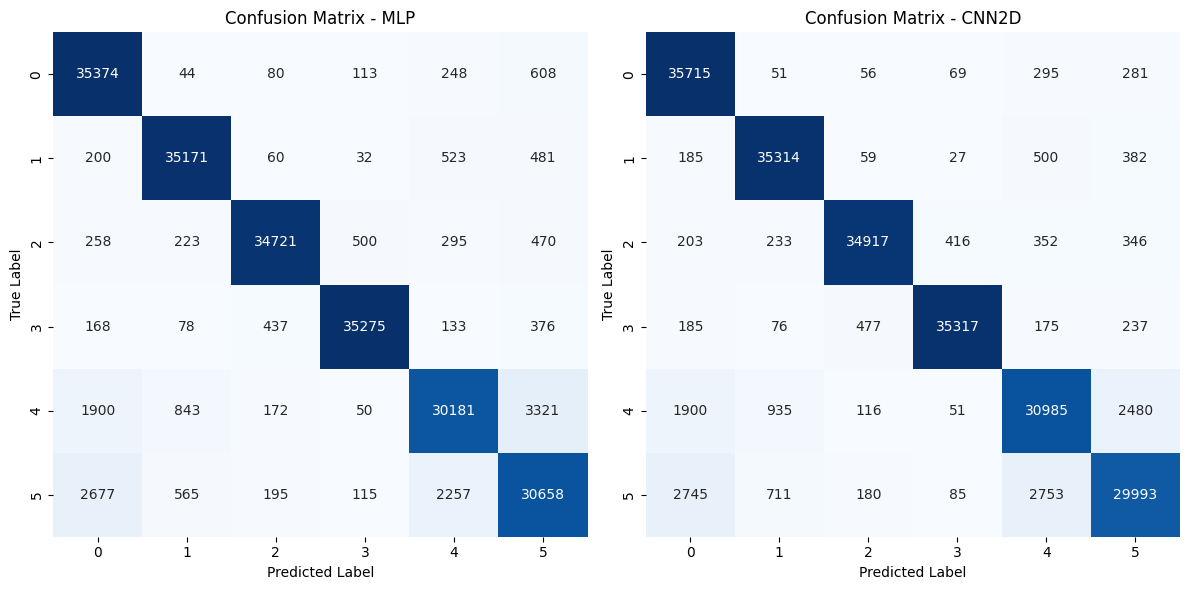

In [ ]:
# Stampa delle matrici di confusione, 2 subplot, una per MLP e una per CNN2D stessa riga

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(confusion_mat_mlp, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Confusion Matrix - MLP')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
sns.heatmap(confusion_mat_cnn2d, annot=True, fmt='d', cmap='Blues', ax=axes[1], cbar=False)
axes[1].set_title('Confusion Matrix - CNN2D')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')    
plt.tight_layout()
plt.show()

# Walking 0 - Jogging 1- Downstairs 2 - Upstairs 3 - Sitting 4 - Standing 5

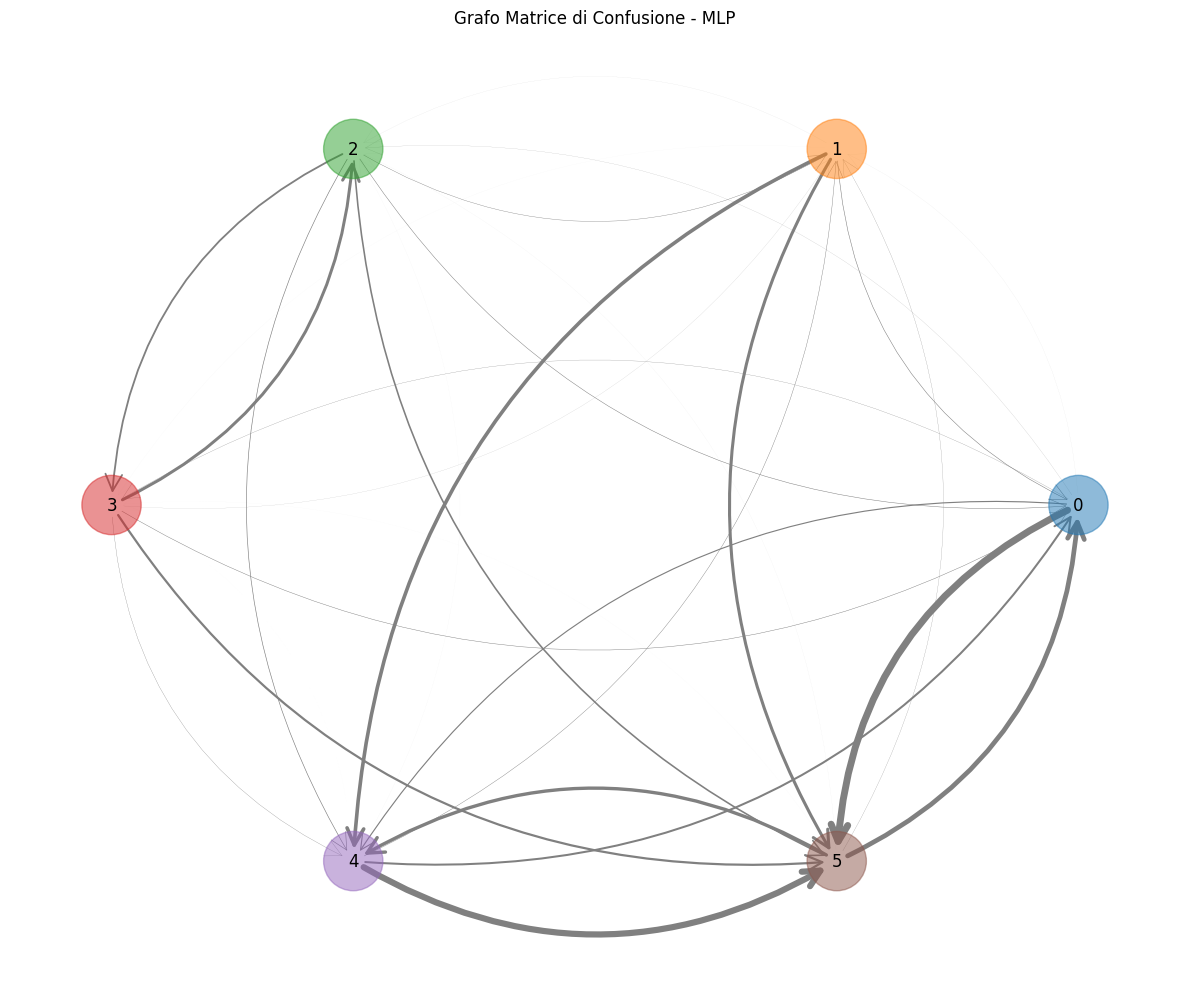

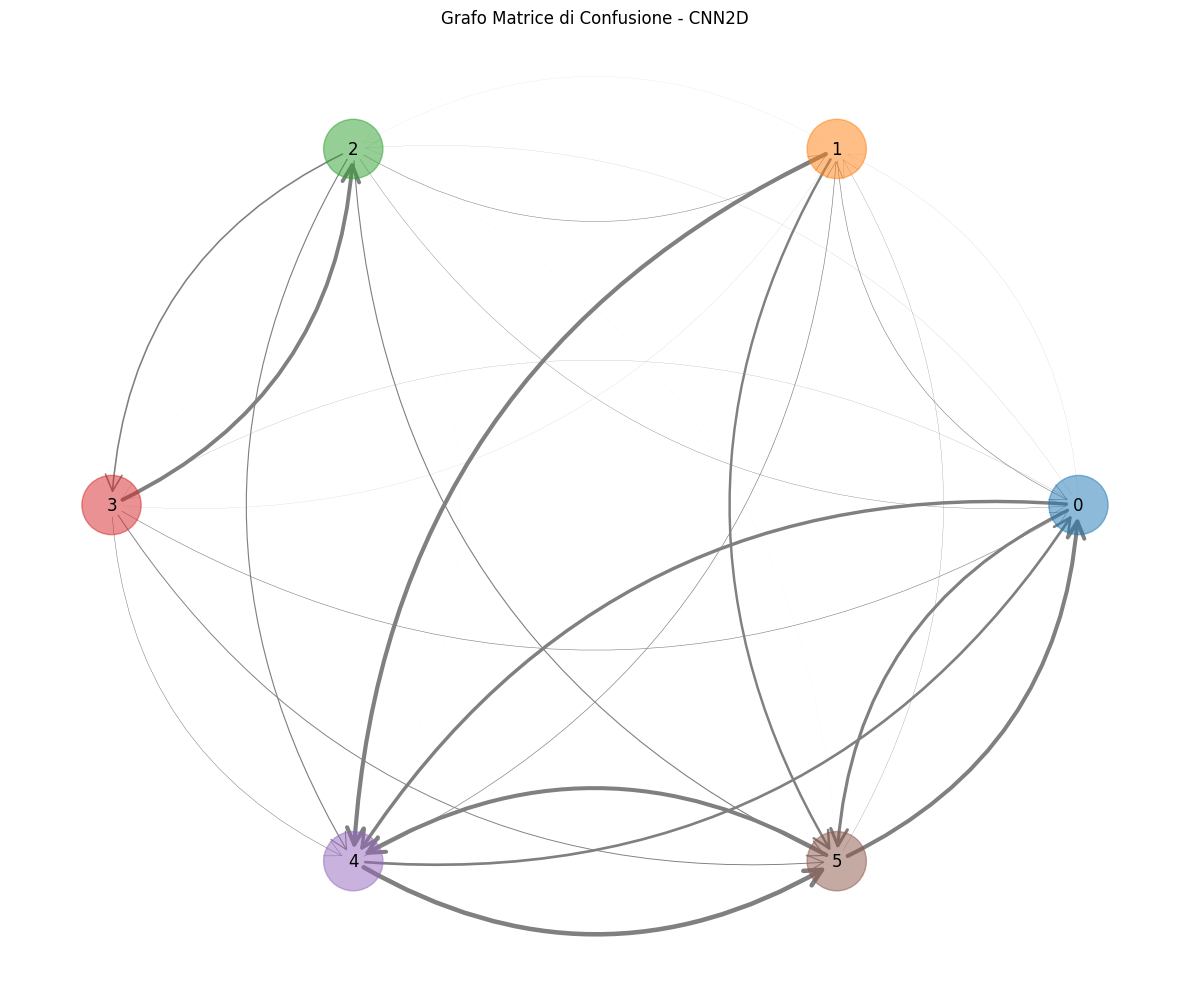

In [ ]:
classes = ['0', '1', '2', '3', '4', '5']
plot_confusion_graph(confusion_mat_mlp, classes, title="Grafo Matrice di Confusione - MLP")
plot_confusion_graph(confusion_mat_cnn2d, classes, title="Grafo Matrice di Confusione - CNN2D")